In [54]:
import geopy
from geopy.extra.rate_limiter import RateLimiter


import pandas as pd
import numpy as np
import geopandas as gpd

from matplotlib import pyplot as plt
import shapely

%matplotlib inline

import contextily as ctx
import requests

#from tqdm.auto import tqdm, trange
from tqdm import tqdm, trange
tqdm.pandas()

from geopy_nominatim_wrapper import NominatimWrapper
from geopy_bestaddress import BestAddress#, LPostBestAddress

import seaborn as sbn

from credentials import here_api_key, bing_api_key, mapbox_api_key, tomtom_api_key, google_api_key, best_client_id, best_client_secret

import plotly.express as px

from zipfile import ZipFile
import json
import random

import os, urllib



fig_path = "output/geocoding/figs"
data_dir = "data/geocoding"
output_dir="output/geocoding/"
# from fpdf import FPDF 

In [6]:
crs =     'epsg:3857'
osm_crs=  'epsg:4326'

In [7]:
os.makedirs(f"{output_dir}/geocoded_data/", exist_ok=True)
os.makedirs(f"{output_dir}/reports/", exist_ok=True)
os.makedirs(fig_path, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)


In [8]:
def add_basemap(ax, zoom='auto'):
    """
    Add a basemap on a plot. Tries first default (Stamen) basemap. If errors, tries OpenStreetMap.Mapnik
    
    Parameters
    ----------
    ax: matplotlib axes
    
    Returns
    -------
        None
    """

    try: 
        ctx.add_basemap(ax, zoom=zoom)
    except requests.HTTPError:
        print("Default basemap doesn't work...")
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoom)

In [9]:
def set_optimal_limits(ax, df):
    """
    Adapt xlim/ylim to a GeoDataFrame point plot to avoid plot to be too wide when 
    points are horizontally aligned, and to narrow when points are vertically aligned

    Usage : 
    
    ax = df.plot()
    set_optimal_limits(ax, df)
    
    Parameters
    ----------
    ax: AxesSubplot
       plot to resize
    df: GeoDataFrame
       data to be plotted

    Returns
    -------
        None
    """
    
    plot_ratio = 1.5 # optimal ratio between "one horizontal degree" and "one vertical degree". It depends of the CRS. 
                     # For "polar" CRS, it may also depend of the place on the globe

    minimal_width=200
   
    margins = 1.1 # Avoid having dots on edges of the plot
    

    # Compute dimension of the data
    xmin, ymin, xmax, ymax = df.total_bounds
    height = (ymax - ymin) 
    width = (xmax - xmin)
    
    opt_height = max(height, width / plot_ratio, minimal_width / plot_ratio)
    opt_width  = max(width , height*plot_ratio, minimal_width)
    
#     print(xmin, ymin, xmax, ymax)
#     print(width, height, opt_width, opt_height)
    # If plot is too narrow, increase xmin. If plot is too wide, increase ylim

    if opt_height > height :
        ymid = (ymax+ymin)/2
        mid_height = opt_height * margins / 2
        ax.set_ylim(ymid - mid_height, ymid + mid_height)
    if opt_width > width:
        xmid = (xmax+xmin)/2
        mid_width = opt_width* margins/2
        ax.set_xlim(xmid - mid_width, xmid + mid_width)

In [10]:
# plot_address(geocoded_data, geocoded_data.iloc[5].address)

# Prepare geocoders

In [183]:
def get_precision(record):
    
    precision_field= {
        "nominatim": "class",
        "nominatim_local": "class",
        "nominatim_wrapper": ("metadata", "placeRank"),
#         "nominatim_wrapper2": "place_rank",
        "here": "MatchLevel",
        "photon_local": ("properties", "type"),
        "bing": "entityType",
        "mapbox": ("properties", "accuracy"),
        "tomtom": "type",
        "trillium": "match_level",
        "google":("geometry", "location_type"),
        "bestaddress": "precision",
        "lpost_bestaddress": "precision"
    }
    
    label_mapping = {
        "nominatim": {"building": "building",
                      "amenity":  "building",
                      "shop":     "building",
                      "place":    "building",
                      "highway":  "street"},
                      
                      
        "nominatim_local": {"building": "building",
                      "amenity":  "building",
                      "shop":     "building",
                      "place":    "building",
                      "highway":  "street"},
        
        "nominatim_wrapper": {"30": "building", 
                              "27": "street",
                              "26": "street",
                              "25": "city",
                              "22": "city",
                              "21": "city",
                              "19": "city",
                              "16": "city",
                              "14": "city"},

        "here": {"houseNumber": "building",
                "street": "street",
                "city": "city",
                "postalCode": "city"},
        "photon_local": {
            "house": "building",
            "locality": "city",
            "street": "street"},
        "bing": { "Address": "building",
                  "RoadBlock": "street",
                 "PopulatedPlace": "city",
                 "Postcode1": "city",
                 "CountryRegion": "country"
                },
        "mapbox": {"rooftop": "building",
                   "point": "building",
                   "interpolated": "building",
                  "street": "street"},
        
        "tomtom": {"Point Address": "building",
                  "Street": "street",
                  "Address Range": "street",
                  "Cross Street": "street",
                  "Geography": "city"},
        "trillium": {0:"building",
                      2: "city",
                      3: "street"},
        "google" : {
            "ROOFTOP": "building",
            "RANGE_INTERPOLATED": "building",
            "GEOMETRIC_CENTER": "street",
            "APPROXIMATE": "city"
        },
        "bestaddress":{
            "building": "building",
            "street":"street",
            "country": "country",
            "city":"city"
        },
        "lpost_bestaddress":{
        "building": "building",
        "street":"street",
        "country": "country"
        }
    }
    
    if record.geocoder == "pelias":
        raw_label = record.location.raw["properties"]
        if raw_label["match_type"] == "exact":
            return "building"
        if "street" in raw_label:
            return "street"
        if "region" in raw_label:
            return "city"
        return "country"
        
    
    try: 
        f = precision_field[record.geocoder]
        mapper = label_mapping[record.geocoder]
        if isinstance(f, str):
            raw_label = record.location.raw[f]
        else: 
            raw_label =  record.location.raw[f[0]][f[1]]
        return mapper[raw_label] if raw_label in mapper else f"[UNKNOWN - {raw_label}]"
    except KeyError: 
        return "[UNKNOWN]"
    
    

In [12]:
geocoders = {}

In [13]:
from geopy.geocoders import Nominatim
geocoders['nominatim_local'] = Nominatim(user_agent="smalsresearch", domain="172.27.0.64:8080", scheme="http", timeout=1000)
geocoders['nominatim'] = Nominatim(user_agent="smalsresearch")


In [14]:
# geocoders['nominatim_local2'] = Nominatim(user_agent="smalsresearch", domain="172.17.0.2:8080", scheme="http", timeout=1000)
# geocoders['nominatim_local'].geocode("Chaussée de Tervueren 59, Auderghem, Bruxelles").raw

In [15]:
geocoders['nominatim_wrapper'] = NominatimWrapper(user_agent="smalsresearch", scheme="http", timeout=1000, domain="172.27.0.64:5000")

In [16]:
# geocoders['nominatim_wrapper'].geocode("Chaussée de Wavre")

In [17]:
# geocoders['lpost_bestaddress'] = LPostBestAddress(user_agent="smalsresearch", scheme="http", timeout=1000, domain="10.1.0.45:7777")
# geocoders['bestaddress'] = BestAddress(user_agent="smalsresearch", scheme="http", timeout=1000, domain="10.1.0.45:7777")

In [19]:
# geocoders['bestaddress'] = BestAddress(user_agent="smalsresearch", scheme="https", timeout=1000, 
#                                        client_id=best_client_id, client_secret=best_client_secret,
#                                        verbose=False
#                                       )

In [20]:
from geopy.geocoders import Pelias
geocoders['pelias'] = Pelias(user_agent="smalsresearch", domain="172.27.0.64:4000", scheme="http", timeout=1000)


In [21]:
from geopy.geocoders import Here
geocoders['here'] = Here(apikey=here_api_key)

In [22]:
from geopy.geocoders import Bing
geocoders['bing'] = Bing(api_key=bing_api_key)

In [23]:
from geopy.geocoders import Photon
geocoders['photon'] = Photon(domain="photon.komoot.io")

geocoders['photon_local'] = Photon(domain="127.0.0.1:2322", scheme="http")

In [24]:
from geopy.geocoders import MapBox
geocoders['mapbox'] = MapBox(api_key=mapbox_api_key)

In [25]:
from geopy.geocoders import TomTom
geocoders['tomtom'] =TomTom(api_key=tomtom_api_key)

In [26]:
#geocoders['tomtom'].geocode("Chaussée de Tervuren 59, 1160 Auderghem")

In [27]:
from geopy.geocoders import GoogleV3
geocoders["google"] = GoogleV3(api_key=google_api_key)

In [28]:
from matplotlib.backends.backend_pdf import PdfPages


# Load data


In [35]:
dataset = "rn_1000"
dataset = "kbo_1000"
dataset = "best_1000"
dataset = "rep_1000"
# ds = "resto_1000"


In [43]:
data = pd.read_csv(f"{data_dir}/{ds}.csv.gz", dtype=str)

mandatory_columns = ["street", "housenumber", "postcode", "city"]
for f in mandatory_columns:
    assert f in data, f"Field {f} is mandatory !!"


In [44]:
data["address"] = data.street.fillna("")+", "+data.housenumber+", "+data.postcode+" "+data.city+", Belgique"
data

street housenumber postcode             city  \
0           de Burburelaan          46     1970  Wezembeek-Oppem   
1          Nachtegalenlaan          35     1950         Kraainem   
2            Rue Tilia(ST)          12     6511         Beaumont   
3           Rue du Hock(N)          36     4121           Neupré   
4          Wuustwezelseweg          95     2990       Wuustwezel   
..                     ...         ...      ...              ...   
995  Vlasbloemstraat(Woes)           6     8640         Vleteren   
996              Abtsdreef         259     2940         Stabroek   
997        Rue des Chalets           5     4030            Liège   
998             Lichterweg           3     2030        Antwerpen   
999       Grote Markt(Kor)          41     8500         Kortrijk   

                                               address  
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...  
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique  
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique  
3            Rue du Hock(N), 36, 4121 Neupré, Belgique  
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique  
..                                                 ...  
995  Vlasbloemstraat(Woes), 6, 8640 Vleteren, Belgique  
996            Abtsdreef, 259, 2940 Stabroek, Belgique  
997           Rue des Chalets, 5, 4030 Liège, Belgique  
998            Lichterweg, 3, 2030 Antwerpen, Belgique  
999      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique  

[1000 rows x 5 columns]

In [45]:
# data

In [46]:
data[data.address.isnull()]

Empty DataFrame
Columns: [street, housenumber, postcode, city, address]
Index: []

In [47]:
pdf = PdfPages(f"output/geocoding/reports/report_{dataset}.pdf")

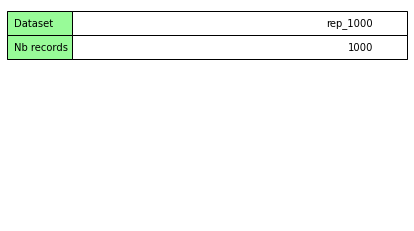

In [48]:
metadata= [["Dataset", dataset],
          ["Nb records", data.shape[0]]]


fig, ax =plt.subplots()
ax.set_axis_off() 
tbl = ax.table(cellText = [ r[1:] for r in metadata],
         rowLabels = [r[0] for r in metadata],
         rowColours = ["palegreen"] * len(metadata),
        loc="upper left")
tbl.scale(1,2)
pdf.savefig( bbox_inches='tight')

# Geocode

In [49]:
try: 
    no_res_timing = pd.read_pickle(f"output/geocoding/no_res_timing_{dataset}.pkl")
except FileNotFoundError: 
    no_res_timing = pd.DataFrame(columns =["address", "geocoder", "duration"] )

In [50]:
#no_res_timing_df.append({"address": "test", "duration": 0.5, "geocoder": "test"}, ignore_index=True)

In [51]:
import datetime
#no_res_timing ={}
def geocode_and_timeit(geocoder, addr):
    global no_res_timing
    start = datetime.datetime.now()
    res = geocoder(addr)
    if res:
        res.raw.update({"duration": datetime.datetime.now()-start})
    else: 
        geocoder_name = list(filter(lambda y: y[1] == geocoder.__self__ , [(x, geocoders[x]) for x in geocoders]))[0][0]
        
        no_res_timing = pd.concat([no_res_timing, pd.DataFrame([{"address":  addr, 
                                              "duration": (datetime.datetime.now()-start).total_seconds(), 
                                              "geocoder": geocoder_name}])])
    return res

In [55]:
geocoded_data_r = []#gpd.GeoDataFrame()
coders=["nominatim_wrapper", "nominatim_local", "here", "bing", "mapbox", "tomtom", "google", "lpost_bestaddress","pelias"]
coders=["nominatim_wrapper", "nominatim_local", "here", "bing", "mapbox", "tomtom", "google"]#,"pelias", "bestaddress"]

# coders=["nominatim_wrapper", "nominatim_local", "here", "bing", "mapbox", "google", "lpost_bestaddress", "tomtom"]
# coders=["tomtom"]
delay={"mapbox":0.5, "nominatim_wrapper":0.01,  "nominatim_local":0.01, "lpost_bestaddress": 0.01, "google":0.5, "tomtom": 0.4}
# from_file = ["nominatim_wrapper", "here", "bing", "mapbox", "tomtom", "google","pelias"] #"here", "bing", "mapbox",  "google",  "lpost_bestaddress", "tomtom"]#"here", "bing", "mapbox", "tomtom", "google",  "nominatim_wrapper","nominatim_local"]#"nominatim_wrapper","nominatim_local", "here", "bing", "mapbox", "tomtom", "trillium", "google"]#"nominatim_local", "photon_local", "here", "bing", "mapbox"]
# from_file = coders
from_file = ["nominatim_wrapper", "nominatim_local", "here", "bing", "mapbox"]
for coder in coders: #geocoders:
    print(coder)
    
    if coder in from_file:
        print("Load from local file...")
        g_data = pd.read_pickle(f"output/geocoding/geocoded_data/geocoded_{dataset}_{coder}.pkl")
    else: 
        
        # Erase no-res timing for this coder for any previous run
        no_res_timing = no_res_timing[no_res_timing.geocoder != coder]
        
        g = geocoders[coder]
        g.geocode_timeit = lambda x: geocode_and_timeit(g.geocode, x)
        geocode = RateLimiter(g.geocode_timeit, min_delay_seconds=delay[coder] if coder in delay else 0.2)

        if coder == "bestaddress": # structured BestAddress
            g_data = data.assign(location=data[["street", "housenumber", "postcode", "city"]].apply(dict, axis=1).progress_apply(geocode)).assign(geocoder=coder)
        else: 
            g_data = data.assign(location=data['address'].progress_apply(geocode)).assign(geocoder=coder)
        g_data.to_pickle(f"output/geocoding/geocoded_data/geocoded_{dataset}_{coder}.pkl")
    
    geocoded_data_r.append(g_data)
    display(g_data)
    

nominatim_wrapper
Load from local file...


street housenumber postcode             city  \
0           de Burburelaan          46     1970  Wezembeek-Oppem   
1          Nachtegalenlaan          35     1950         Kraainem   
2            Rue Tilia(ST)          12     6511         Beaumont   
3           Rue du Hock(N)          36     4121           Neupré   
4          Wuustwezelseweg          95     2990       Wuustwezel   
..                     ...         ...      ...              ...   
995  Vlasbloemstraat(Woes)           6     8640         Vleteren   
996              Abtsdreef         259     2940         Stabroek   
997        Rue des Chalets           5     4030            Liège   
998             Lichterweg           3     2030        Antwerpen   
999       Grote Markt(Kor)          41     8500         Kortrijk   

                                               address  \
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3            Rue du Hock(N), 36, 4121 Neupré, Belgique   
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
..                                                 ...   
995  Vlasbloemstraat(Woes), 6, 8640 Vleteren, Belgique   
996            Abtsdreef, 259, 2940 Stabroek, Belgique   
997           Rue des Chalets, 5, 4030 Liège, Belgique   
998            Lichterweg, 3, 2030 Antwerpen, Belgique   
999      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   

                                              location           geocoder  
0    (Oscar de Burburelaan, Wezembeek, Wezembeek-Op...  nominatim_wrapper  
1    (35, Nachtegalenlaan, Kraainem, Halle-Vilvoord...  nominatim_wrapper  
2    (Rue Tilia, Strée, Beaumont, Thuin, Hainaut, W...  nominatim_wrapper  
3    (36, Rue du Hock, Neuville-en-Condroz, Neupré,...  nominatim_wrapper  
4    (95, Wuustwezelseweg, Loenhout, Wuustwezel, An...  nominatim_wrapper  
..                                                 ...                ...  
995  (Vlasbloemstraat, Woesten, Vleteren, Ieper, We...  nominatim_wrapper  
996  (259, Abtsdreef, Stabroek, Antwerpen, Vlaander...  nominatim_wrapper  
997  (5, Rue des Chalets, Vennes, Grivegnée, Liège,...  nominatim_wrapper  
998  (Lichterweg, Antwerpen, Vlaanderen, 2030, Belg...  nominatim_wrapper  
999  (41, Grote Markt, Begijnhof Sint-Elisabeth, Ko...  nominatim_wrapper  

[1000 rows x 7 columns]

nominatim_local
Load from local file...


street housenumber postcode             city  \
0           de Burburelaan          46     1970  Wezembeek-Oppem   
1          Nachtegalenlaan          35     1950         Kraainem   
2            Rue Tilia(ST)          12     6511         Beaumont   
3           Rue du Hock(N)          36     4121           Neupré   
4          Wuustwezelseweg          95     2990       Wuustwezel   
..                     ...         ...      ...              ...   
995  Vlasbloemstraat(Woes)           6     8640         Vleteren   
996              Abtsdreef         259     2940         Stabroek   
997        Rue des Chalets           5     4030            Liège   
998             Lichterweg           3     2030        Antwerpen   
999       Grote Markt(Kor)          41     8500         Kortrijk   

                                               address  \
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3            Rue du Hock(N), 36, 4121 Neupré, Belgique   
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
..                                                 ...   
995  Vlasbloemstraat(Woes), 6, 8640 Vleteren, Belgique   
996            Abtsdreef, 259, 2940 Stabroek, Belgique   
997           Rue des Chalets, 5, 4030 Liège, Belgique   
998            Lichterweg, 3, 2030 Antwerpen, Belgique   
999      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   

                                              location         geocoder  
0    (Oscar de Burburelaan, Wezembeek, Wezembeek-Op...  nominatim_local  
1    (35, Nachtegalenlaan, Kraainem, Halle-Vilvoord...  nominatim_local  
2    (Rue Tilia, Strée, Beaumont, Thuin, Hainaut, W...  nominatim_local  
3    (36, Rue du Hock, Neuville-en-Condroz, Neupré,...  nominatim_local  
4    (95, Wuustwezelseweg, Loenhout, Wuustwezel, An...  nominatim_local  
..                                                 ...              ...  
995                                               None  nominatim_local  
996  (259, Abtsdreef, Stabroek, Antwerpen, Vlaander...  nominatim_local  
997  (5, Rue des Chalets, Vennes, Grivegnée, Liège,...  nominatim_local  
998  (Lichterweg, Antwerpen, Vlaanderen, 2030, Belg...  nominatim_local  
999                                               None  nominatim_local  

[1000 rows x 7 columns]

here
Load from local file...


street housenumber postcode             city  \
0           de Burburelaan          46     1970  Wezembeek-Oppem   
1          Nachtegalenlaan          35     1950         Kraainem   
2            Rue Tilia(ST)          12     6511         Beaumont   
3           Rue du Hock(N)          36     4121           Neupré   
4          Wuustwezelseweg          95     2990       Wuustwezel   
..                     ...         ...      ...              ...   
995  Vlasbloemstraat(Woes)           6     8640         Vleteren   
996              Abtsdreef         259     2940         Stabroek   
997        Rue des Chalets           5     4030            Liège   
998             Lichterweg           3     2030        Antwerpen   
999       Grote Markt(Kor)          41     8500         Kortrijk   

                                               address  \
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3            Rue du Hock(N), 36, 4121 Neupré, Belgique   
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
..                                                 ...   
995  Vlasbloemstraat(Woes), 6, 8640 Vleteren, Belgique   
996            Abtsdreef, 259, 2940 Stabroek, Belgique   
997           Rue des Chalets, 5, 4030 Liège, Belgique   
998            Lichterweg, 3, 2030 Antwerpen, Belgique   
999      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   

                                              location geocoder  
0    (Oscar de Burburelaan 46, 1970 Wezembeek-Oppem...     here  
1    (Nachtegalenlaan 35, 1950 Kraainem, België, Kr...     here  
2    (Rue Tilia 12, 6511 Beaumont, Belgique, Beaumo...     here  
3    (Rue du Hock 36, 4121 Neupré, Belgique, Neupré...     here  
4    (Wuustwezelseweg 95, 2990 Wuustwezel, België, ...     here  
..                                                 ...      ...  
995  (Vlasbloemstraat 6, 8640 Vleteren, België, Vle...     here  
996  (Abtsdreef 259, 2940 Stabroek, België, Stabroe...     here  
997  (Rue des Chalets 5, 4030 Liège, Belgique, Lièg...     here  
998  (Lichterweg, 2030 Antwerpen, België, Antwerpen...     here  
999  (Grote Markt 41, 8500 Kortrijk, België, Kortri...     here  

[1000 rows x 7 columns]

bing
Load from local file...


street housenumber postcode             city  \
0           de Burburelaan          46     1970  Wezembeek-Oppem   
1          Nachtegalenlaan          35     1950         Kraainem   
2            Rue Tilia(ST)          12     6511         Beaumont   
3           Rue du Hock(N)          36     4121           Neupré   
4          Wuustwezelseweg          95     2990       Wuustwezel   
..                     ...         ...      ...              ...   
995  Vlasbloemstraat(Woes)           6     8640         Vleteren   
996              Abtsdreef         259     2940         Stabroek   
997        Rue des Chalets           5     4030            Liège   
998             Lichterweg           3     2030        Antwerpen   
999       Grote Markt(Kor)          41     8500         Kortrijk   

                                               address  \
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3            Rue du Hock(N), 36, 4121 Neupré, Belgique   
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
..                                                 ...   
995  Vlasbloemstraat(Woes), 6, 8640 Vleteren, Belgique   
996            Abtsdreef, 259, 2940 Stabroek, Belgique   
997           Rue des Chalets, 5, 4030 Liège, Belgique   
998            Lichterweg, 3, 2030 Antwerpen, Belgique   
999      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   

                                              location geocoder  
0    (Avenue de Burbure 46, Wezembeek-Oppem, Flemis...     bing  
1    (Avenue des Rossignols 35, Kraainem, Flemish R...     bing  
2    (Rue Tilia 12, Beaumont, Walloon Region 6511, ...     bing  
3    (Rue du Hock 36, Neuville-en-Condroz, Walloon ...     bing  
4    (Wuustwezelseweg 95, Wuustwezel, Flemish Regio...     bing  
..                                                 ...      ...  
995  (Vlasbloemstraat 6, Woesten, Flemish Region 86...     bing  
996  (Abtsdreef 259, Stabroek, Flemish Region 2940,...     bing  
997  (Rue des Chalets 5, Liège, Walloon Region 4030...     bing  
998  (Lichterweg, Antwerp, Flemish Region 2000, Bel...     bing  
999  (Grote Markt 41, Kortrijk, Flemish Region 8500...     bing  

[1000 rows x 7 columns]

mapbox
Load from local file...


street housenumber postcode             city  \
0           de Burburelaan          46     1970  Wezembeek-Oppem   
1          Nachtegalenlaan          35     1950         Kraainem   
2            Rue Tilia(ST)          12     6511         Beaumont   
3           Rue du Hock(N)          36     4121           Neupré   
4          Wuustwezelseweg          95     2990       Wuustwezel   
..                     ...         ...      ...              ...   
995  Vlasbloemstraat(Woes)           6     8640         Vleteren   
996              Abtsdreef         259     2940         Stabroek   
997        Rue des Chalets           5     4030            Liège   
998             Lichterweg           3     2030        Antwerpen   
999       Grote Markt(Kor)          41     8500         Kortrijk   

                                               address  \
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3            Rue du Hock(N), 36, 4121 Neupré, Belgique   
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
..                                                 ...   
995  Vlasbloemstraat(Woes), 6, 8640 Vleteren, Belgique   
996            Abtsdreef, 259, 2940 Stabroek, Belgique   
997           Rue des Chalets, 5, 4030 Liège, Belgique   
998            Lichterweg, 3, 2030 Antwerpen, Belgique   
999      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   

                                              location geocoder  
0    (Oscar De Burburelaan - Avenue Oscar De Burbur...   mapbox  
1    (Nachtegalenlaan 35, 1950 Kraainem, Flemish Br...   mapbox  
2    (6511, Beaumont, Hainaut, Belgium, (50.276633,...   mapbox  
3    (Rue Du Hock, 4121 Neupré, Liege, Belgium, (50...   mapbox  
4    (Wuustwezelseweg 95, 2990 Wuustwezel, Antwerp,...   mapbox  
..                                                 ...      ...  
995  (Vlasbloemstraat, 8640 Vleteren, West Flanders...   mapbox  
996  (Abtsdreef 259, 2940 Stabroek, Antwerp, Belgiu...   mapbox  
997  (Rue Des Chalets 5, 4030 Liège, Liege, Belgium...   mapbox  
998  (Lichterweg, 2030 Antwerpen, Antwerp, Belgium,...   mapbox  
999  (Grote Markt, Grote Markt, Kortrijk, West Flan...   mapbox  

[1000 rows x 7 columns]

tomtom


 21%|██        | 206/1000 [00:43<02:51,  4.64it/s]RateLimiter caught an error, retrying (0/2 tries). Called with (*('Place Saint-Denis, 65/67, 1190 Forest, Belgique',), **{}).
Traceback (most recent call last):
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/geocoders/base.py", line 368, in _call_geocoder
    result = self.adapter.get_json(url, timeout=timeout, headers=req_headers)
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/adapters.py", line 438, in get_json
    resp = self._request(url, timeout=timeout, headers=headers)
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/adapters.py", line 466, in _request
    raise AdapterHTTPError(
geopy.adapters.AdapterHTTPError: Non-successful status code 404

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/extra/rate_limiter.py", line 136, in _retries_gen

RateLimiter swallowed an error after 2 retries. Called with (*('Clos des Lavandières, 5/31, 4000 Liège, Belgique',), **{}).
Traceback (most recent call last):
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/geocoders/base.py", line 368, in _call_geocoder
    result = self.adapter.get_json(url, timeout=timeout, headers=req_headers)
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/adapters.py", line 438, in get_json
    resp = self._request(url, timeout=timeout, headers=headers)
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/adapters.py", line 466, in _request
    raise AdapterHTTPError(
geopy.adapters.AdapterHTTPError: Non-successful status code 404

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/extra/rate_limiter.py", line 274, in __call__
    res = self.func(*args, **kwargs)
  File "/tmp/ipyke

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Rue des Faînes, 21/23, 1120 Bruxelles, Belgique',), **{}).
Traceback (most recent call last):
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/geocoders/base.py", line 368, in _call_geocoder
    result = self.adapter.get_json(url, timeout=timeout, headers=req_headers)
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/adapters.py", line 438, in get_json
    resp = self._request(url, timeout=timeout, headers=headers)
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/adapters.py", line 466, in _request
    raise AdapterHTTPError(
geopy.adapters.AdapterHTTPError: Non-successful status code 404

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/extra/rate_limiter.py", line 136, in _retries_gen
    yield i  # Run the function.
  File "/home/vb

 65%|██████▌   | 654/1000 [03:10<01:10,  4.89it/s]RateLimiter caught an error, retrying (0/2 tries). Called with (*('Chaussée de Lille(OR), 479/2, 7501 Tournai, Belgique',), **{}).
Traceback (most recent call last):
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/geocoders/base.py", line 368, in _call_geocoder
    result = self.adapter.get_json(url, timeout=timeout, headers=req_headers)
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/adapters.py", line 438, in get_json
    resp = self._request(url, timeout=timeout, headers=headers)
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/adapters.py", line 466, in _request
    raise AdapterHTTPError(
geopy.adapters.AdapterHTTPError: Non-successful status code 404

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/extra/rate_limiter.py", line 136, in _retrie

RateLimiter swallowed an error after 2 retries. Called with (*('Rue Pavé du Gosson, 243/, 4420 Saint-Nicolas, Belgique',), **{}).
Traceback (most recent call last):
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/geocoders/base.py", line 368, in _call_geocoder
    result = self.adapter.get_json(url, timeout=timeout, headers=req_headers)
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/adapters.py", line 438, in get_json
    resp = self._request(url, timeout=timeout, headers=headers)
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/adapters.py", line 466, in _request
    raise AdapterHTTPError(
geopy.adapters.AdapterHTTPError: Non-successful status code 404

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/extra/rate_limiter.py", line 274, in __call__
    res = self.func(*args, **kwargs)
  File "/tmp

street housenumber postcode             city  \
0           de Burburelaan          46     1970  Wezembeek-Oppem   
1          Nachtegalenlaan          35     1950         Kraainem   
2            Rue Tilia(ST)          12     6511         Beaumont   
3           Rue du Hock(N)          36     4121           Neupré   
4          Wuustwezelseweg          95     2990       Wuustwezel   
..                     ...         ...      ...              ...   
995  Vlasbloemstraat(Woes)           6     8640         Vleteren   
996              Abtsdreef         259     2940         Stabroek   
997        Rue des Chalets           5     4030            Liège   
998             Lichterweg           3     2030        Antwerpen   
999       Grote Markt(Kor)          41     8500         Kortrijk   

                                               address  \
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3            Rue du Hock(N), 36, 4121 Neupré, Belgique   
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
..                                                 ...   
995  Vlasbloemstraat(Woes), 6, 8640 Vleteren, Belgique   
996            Abtsdreef, 259, 2940 Stabroek, Belgique   
997           Rue des Chalets, 5, 4030 Liège, Belgique   
998            Lichterweg, 3, 2030 Antwerpen, Belgique   
999      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   

                                              location geocoder  
0    (De Burburelaan 46, 1970 Wezembeek-Oppem, (50....   tomtom  
1    (Nachtegalenlaan 35, 1950 Kraainem, (50.85665,...   tomtom  
2    (Rue de la Station 12, 6511 Beaumont, (50.2741...   tomtom  
3    (Rue du Hock 36, 4121 Neupré, (50.55351, 5.455...   tomtom  
4    (Wuustwezelseweg 95, 2990 Wuustwezel, (51.4005...   tomtom  
..                                                 ...      ...  
995  (Vlasbloemstraat 6, 8640 Vleteren, (50.91206, ...   tomtom  
996  (Abtsdreef 259, 2940 Stabroek, (51.34338, 4.34...   tomtom  
997  (Rue des Chalets 5, 4030 Liège, (50.62815, 5.5...   tomtom  
998   (Lichterweg, 2000 Antwerpen, (51.24925, 4.3869))   tomtom  
999  (Grote Markt 41, 8500 Kortrijk, (50.82714, 3.2...   tomtom  

[1000 rows x 7 columns]

google


100%|██████████| 1000/1000 [08:20<00:00,  2.00it/s]


street housenumber postcode             city  \
0           de Burburelaan          46     1970  Wezembeek-Oppem   
1          Nachtegalenlaan          35     1950         Kraainem   
2            Rue Tilia(ST)          12     6511         Beaumont   
3           Rue du Hock(N)          36     4121           Neupré   
4          Wuustwezelseweg          95     2990       Wuustwezel   
..                     ...         ...      ...              ...   
995  Vlasbloemstraat(Woes)           6     8640         Vleteren   
996              Abtsdreef         259     2940         Stabroek   
997        Rue des Chalets           5     4030            Liège   
998             Lichterweg           3     2030        Antwerpen   
999       Grote Markt(Kor)          41     8500         Kortrijk   

                                               address  \
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3            Rue du Hock(N), 36, 4121 Neupré, Belgique   
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
..                                                 ...   
995  Vlasbloemstraat(Woes), 6, 8640 Vleteren, Belgique   
996            Abtsdreef, 259, 2940 Stabroek, Belgique   
997           Rue des Chalets, 5, 4030 Liège, Belgique   
998            Lichterweg, 3, 2030 Antwerpen, Belgique   
999      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   

                                              location geocoder  
0    (Oscar de Burburelaan 46, 1970 Wezembeek-Oppem...   google  
1    (Nachtegalenlaan 35, 1950 Kraainem, Belgium, (...   google  
2    (Rue Tilia 12, 6511 Beaumont, Belgium, (50.273...   google  
3    (Rue du Hock 36, 4121 Neupré, Belgium, (50.553...   google  
4    (Wuustwezelseweg 95, 2990 Wuustwezel, Belgium,...   google  
..                                                 ...      ...  
995  (Vlasbloemstraat, 8640 Vleteren, Belgium, (50....   google  
996  (Abtsdreef 259, 2940 Stabroek, Belgium, (51.34...   google  
997  (Rue des Chalets 5, 4030 Liège, Belgium, (50.6...   google  
998  (Lichterweg 3, 2030 Antwerpen, Belgium, (51.24...   google  
999        (Kortrijk, Belgium, (50.826806, 3.2543899))   google  

[1000 rows x 7 columns]

## Gather results

In [56]:
geocoded_data = pd.concat(geocoded_data_r).reset_index(drop=True)
geocoded_data = geocoded_data[geocoded_data.location.notnull()]
geocoded_data

street housenumber postcode             city  \
0            de Burburelaan          46     1970  Wezembeek-Oppem   
1           Nachtegalenlaan          35     1950         Kraainem   
2             Rue Tilia(ST)          12     6511         Beaumont   
3            Rue du Hock(N)          36     4121           Neupré   
4           Wuustwezelseweg          95     2990       Wuustwezel   
...                     ...         ...      ...              ...   
6995  Vlasbloemstraat(Woes)           6     8640         Vleteren   
6996              Abtsdreef         259     2940         Stabroek   
6997        Rue des Chalets           5     4030            Liège   
6998             Lichterweg           3     2030        Antwerpen   
6999       Grote Markt(Kor)          41     8500         Kortrijk   

                                                address  \
0     de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1          Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2            Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3             Rue du Hock(N), 36, 4121 Neupré, Belgique   
4        Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
...                                                 ...   
6995  Vlasbloemstraat(Woes), 6, 8640 Vleteren, Belgique   
6996            Abtsdreef, 259, 2940 Stabroek, Belgique   
6997           Rue des Chalets, 5, 4030 Liège, Belgique   
6998            Lichterweg, 3, 2030 Antwerpen, Belgique   
6999      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   

                                               location           geocoder  
0     (Oscar de Burburelaan, Wezembeek, Wezembeek-Op...  nominatim_wrapper  
1     (35, Nachtegalenlaan, Kraainem, Halle-Vilvoord...  nominatim_wrapper  
2     (Rue Tilia, Strée, Beaumont, Thuin, Hainaut, W...  nominatim_wrapper  
3     (36, Rue du Hock, Neuville-en-Condroz, Neupré,...  nominatim_wrapper  
4     (95, Wuustwezelseweg, Loenhout, Wuustwezel, An...  nominatim_wrapper  
...                                                 ...                ...  
6995  (Vlasbloemstraat, 8640 Vleteren, Belgium, (50....             google  
6996  (Abtsdreef 259, 2940 Stabroek, Belgium, (51.34...             google  
6997  (Rue des Chalets 5, 4030 Liège, Belgium, (50.6...             google  
6998  (Lichterweg 3, 2030 Antwerpen, Belgium, (51.24...             google  
6999        (Kortrijk, Belgium, (50.826806, 3.2543899))             google  

[6850 rows x 7 columns]

In [57]:
geocoded_data.geocoder.value_counts()

here                 1000
bing                 1000
mapbox               1000
google               1000
nominatim_wrapper     994
tomtom                993
nominatim_local       863
Name: geocoder, dtype: int64

In [58]:
# data[~data.address.isin(geocoded_data[geocoded_data.geocoder == "lpost_bestaddress"].address)]

## Duration

In [59]:
geocoded_data["duration"] = geocoded_data["location"].apply(lambda loc: loc.raw["duration"] if loc and "duration" in loc.raw else None).dt.total_seconds()

In [60]:
geocoded_data.groupby("geocoder").address.count().sum()#["duration"]


6850

In [61]:
no_res_timing.to_pickle(f"output/geocoding/no_res_timing_{dataset}.pkl")

In [62]:
# if len(no_res_timing) >0:
#     no_res_timing_df = pd.concat([pd.DataFrame(no_res_timing[x]).rename(columns={0:"address", 1:"duration"}).assign(geocoder=x) for x in no_res_timing])#.drop("index", axis=1)
#     #pd.DataFrame(no_res_timing).unstack().rename("duration").reset_index().rename(columns={"level_0": "geocoder"}).drop("level_1", axis=1)
#     no_res_timing_df["duration"] = no_res_timing_df["duration"].dt.total_seconds()
    
#     no_res_timing_df.to_pickle(f"output/geocoding/no_res_timing_{dataset}.pkl")
# else: 
#     try: 
#         no_res_timing_df = pd.read_pickle(f"output/geocoding/no_res_timing_{dataset}.pkl")
#     except FileNotFoundError: 
#         no_res_timing_df = pd.DataFrame(columns =["address", "geocoder", "duration"] )
# no_res_timing_df

In [63]:
geocoded_data_duration = pd.concat([geocoded_data[(geocoded_data.geocoder!="trillium")].assign(with_result=True), no_res_timing.assign(with_result=False)])
geocoded_data_duration = geocoded_data_duration.reset_index()[["address", "geocoder", "duration", "with_result"]]
geocoded_data_duration["address"] = geocoded_data_duration["address"].astype(str)

In [64]:
geocoded_data_duration

address           geocoder  \
0     de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...  nominatim_wrapper   
1          Nachtegalenlaan, 35, 1950 Kraainem, Belgique  nominatim_wrapper   
2            Rue Tilia(ST), 12, 6511 Beaumont, Belgique  nominatim_wrapper   
3             Rue du Hock(N), 36, 4121 Neupré, Belgique  nominatim_wrapper   
4        Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique  nominatim_wrapper   
...                                                 ...                ...   
6988          Ronse Baan, 5, 9690 Kluisbergen, Belgique    nominatim_local   
6989  Libramont,Avenue de Houffalize, 42b, 6800 Libr...    nominatim_local   
6990  Rue Prisonniers de Guerre(FLM), 22, 6141 Fonta...    nominatim_local   
6991  Vlasbloemstraat(Woes), 6, 8640 Vleteren, Belgique    nominatim_local   
6992      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique    nominatim_local   

      duration  with_result  
0     0.141377         True  
1     0.092073         True  
2     0.053527         True  
3     0.089439         True  
4     0.142177         True  
...        ...          ...  
6988  0.026613        False  
6989  0.032957        False  
6990  0.004410        False  
6991  0.003933        False  
6992  0.029079        False  

[6993 rows x 4 columns]

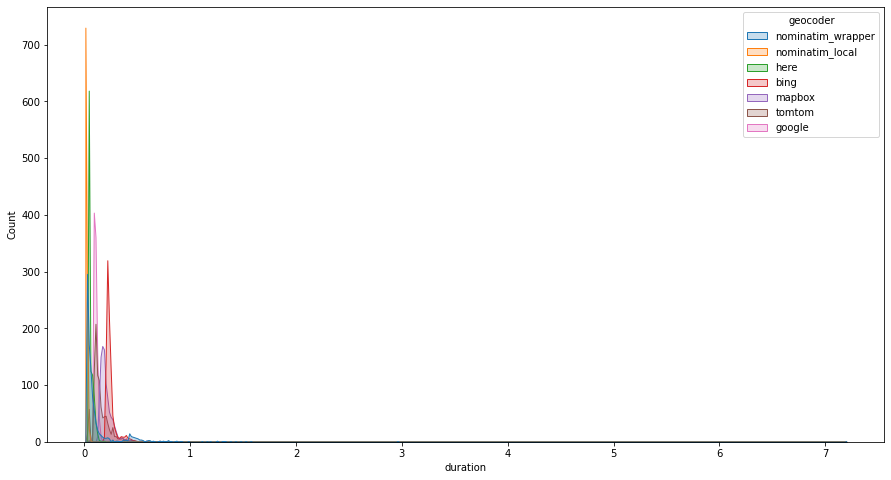

In [65]:
plt.figure(figsize=(15,8))
sbn.histplot(geocoded_data_duration, x="duration", hue="geocoder", element="poly", )
pdf.savefig(bbox_inches='tight')

In [66]:
# pd.concat([geocoded_data, no_res_timing_df]).groupby("geocoder").duration.mean()

In [67]:
# geocoded_data.groupby("geocoder").duration.mean()

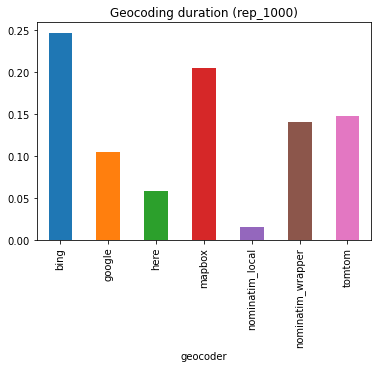

In [68]:
colors = [f"C{i}" for i in range(geocoded_data.geocoder.nunique())]

geocoded_data_duration.groupby("geocoder").duration.mean().plot.bar(color=colors, title=f"Geocoding duration ({ds})")
plt.savefig(f'{fig_path}/geocoding_speed.png', dpi=150,  bbox_inches='tight')
pdf.savefig(bbox_inches='tight')

<AxesSubplot:title={'center':'Geocoding duration (rep_1000)'}, xlabel='geocoder'>

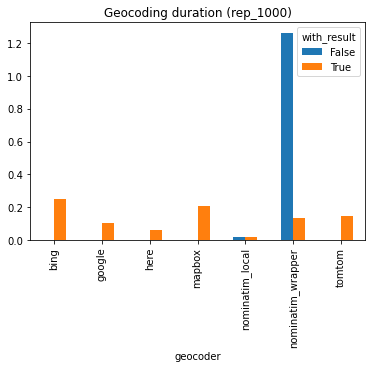

In [69]:
geocoded_data_duration.groupby(["geocoder", "with_result"]).duration.mean().unstack().plot.bar(title=f"Geocoding duration ({ds})")

In [70]:
# geocoded_data_duration[geocoded_data_duration.geocoder=="tomtom"]

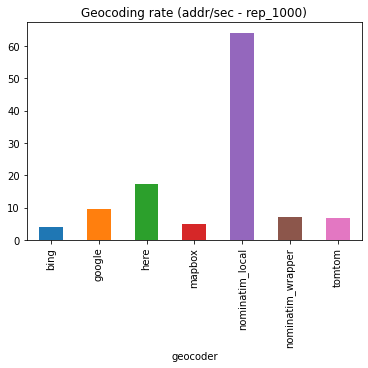

In [71]:
colors = [f"C{i}" for i in range(geocoded_data.geocoder.nunique())]

(1/geocoded_data_duration.groupby("geocoder").duration.mean()).plot.bar(color=colors, title=f"Geocoding rate (addr/sec - {ds})")
# plt.savefig(f'{fig_path}/geocoding_speed_rate.png', dpi=150,  bbox_inches='tight')
pdf.savefig(bbox_inches='tight')

In [72]:
geocoded_data_duration[geocoded_data_duration[["address", "geocoder"]].duplicated(keep=False)]

address           geocoder  \
45    Avenue de Tervueren, 402, 1150 Woluwe-Saint-Pi...  nominatim_wrapper   
242         Brusselstraat, 51, 2018 Antwerpen, Belgique  nominatim_wrapper   
273                    Schans, 1, 2480 Dessel, Belgique  nominatim_wrapper   
320   Avenue de Tervueren, 402, 1150 Woluwe-Saint-Pi...  nominatim_wrapper   
948                    Schans, 1, 2480 Dessel, Belgique  nominatim_wrapper   
980         Brusselstraat, 51, 2018 Antwerpen, Belgique  nominatim_wrapper   
1035  Avenue de Tervueren, 402, 1150 Woluwe-Saint-Pi...    nominatim_local   
1210        Brusselstraat, 51, 2018 Antwerpen, Belgique    nominatim_local   
1237                   Schans, 1, 2480 Dessel, Belgique    nominatim_local   
1275  Avenue de Tervueren, 402, 1150 Woluwe-Saint-Pi...    nominatim_local   
1821                   Schans, 1, 2480 Dessel, Belgique    nominatim_local   
1849        Brusselstraat, 51, 2018 Antwerpen, Belgique    nominatim_local   
1903  Avenue de Tervueren, 402, 1150 Woluwe-Saint-Pi...               here   
2100        Brusselstraat, 51, 2018 Antwerpen, Belgique               here   
2131                   Schans, 1, 2480 Dessel, Belgique               here   
2178  Avenue de Tervueren, 402, 1150 Woluwe-Saint-Pi...               here   
2809                   Schans, 1, 2480 Dessel, Belgique               here   
2841        Brusselstraat, 51, 2018 Antwerpen, Belgique               here   
2903  Avenue de Tervueren, 402, 1150 Woluwe-Saint-Pi...               bing   
3100        Brusselstraat, 51, 2018 Antwerpen, Belgique               bing   
3131                   Schans, 1, 2480 Dessel, Belgique               bing   
3178  Avenue de Tervueren, 402, 1150 Woluwe-Saint-Pi...               bing   
3809                   Schans, 1, 2480 Dessel, Belgique               bing   
3841        Brusselstraat, 51, 2018 Antwerpen, Belgique               bing   
3903  Avenue de Tervueren, 402, 1150 Woluwe-Saint-Pi...             mapbox   
4100        Brusselstraat, 51, 2018 Antwerpen, Belgique             mapbox   
4131                   Schans, 1, 2480 Dessel, Belgique             mapbox   
4178  Avenue de Tervueren, 402, 1150 Woluwe-Saint-Pi...             mapbox   
4809                   Schans, 1, 2480 Dessel, Belgique             mapbox   
4841        Brusselstraat, 51, 2018 Antwerpen, Belgique             mapbox   
4903  Avenue de Tervueren, 402, 1150 Woluwe-Saint-Pi...             tomtom   
5098        Brusselstraat, 51, 2018 Antwerpen, Belgique             tomtom   
5129                   Schans, 1, 2480 Dessel, Belgique             tomtom   
5175  Avenue de Tervueren, 402, 1150 Woluwe-Saint-Pi...             tomtom   
5802                   Schans, 1, 2480 Dessel, Belgique             tomtom   
5834        Brusselstraat, 51, 2018 Antwerpen, Belgique             tomtom   
5896  Avenue de Tervueren, 402, 1150 Woluwe-Saint-Pi...             google   
6093        Brusselstraat, 51, 2018 Antwerpen, Belgique             google   
6124                   Schans, 1, 2480 Dessel, Belgique             google   
6171  Avenue de Tervueren, 402, 1150 Woluwe-Saint-Pi...             google   
6802                   Schans, 1, 2480 Dessel, Belgique             google   
6834        Brusselstraat, 51, 2018 Antwerpen, Belgique             google   

      duration  with_result  
45    0.049282         True  
242   0.022541         True  
273   0.085974         True  
320   0.028154         True  
948   0.018238         True  
980   0.021061         True  
1035  0.017131         True  
1210  0.010548         True  
1237  0.008944         True  
1275  0.016570         True  
1821  0.009024         True  
1849  0.011995         True  
1903  0.058132         True  
2100  0.047351         True  
2131  0.043797         True  
2178  0.036146         True  
2809  0.036912         True  
2841  0.037403         True  
2903  0.247110         True  
3100  0.295504         True  
3131  0.205078         True  
3178  0.245272         True  
380

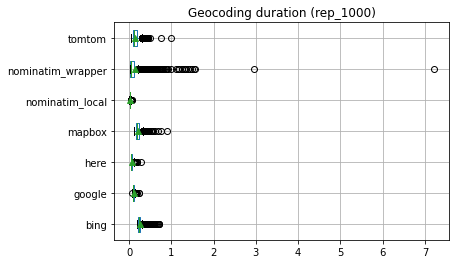

In [73]:
d = geocoded_data_duration.drop_duplicates(subset=["address",  "geocoder"]).pivot(index="address", columns="geocoder", values="duration")
ax = d.boxplot(showmeans=True, vert=False)
plt.title(f"Geocoding duration ({ds})")
plt.savefig(f'{fig_path}/geocoding_speed_boxplot.png', dpi=150,  bbox_inches='tight')
pdf.savefig(bbox_inches='tight')
# ax.set_yscale("log")

In [74]:
geocoded_data[geocoded_data.geocoder!="trillium"][["geocoder", "duration"]].groupby("geocoder").describe()


duration                                                    \
                     count      mean       std       min       25%       50%   
geocoder                                                                       
bing                1000.0  0.246689  0.064410  0.178192  0.215040  0.227579   
google              1000.0  0.104172  0.016364  0.029333  0.093228  0.101291   
here                1000.0  0.057947  0.021839  0.036146  0.044667  0.047356   
mapbox              1000.0  0.204780  0.069715  0.035226  0.163319  0.186863   
nominatim_local      863.0  0.015044  0.007614  0.008336  0.010221  0.011859   
nominatim_wrapper    994.0  0.134000  0.310479  0.017769  0.028948  0.051965   
tomtom               993.0  0.147418  0.080252  0.032122  0.101867  0.124457   

                                       
                        75%       max  
geocoder                               
bing               0.248703  0.716179  
google             0.112350  0.241547  
here               0.068594  0.269961  
mapbox             0.224722  0.884691  
nominatim_local    0.016756  0.062157  
nominatim_wrapper  0.100074  7.205787  
tomtom             0.178429  0.980041

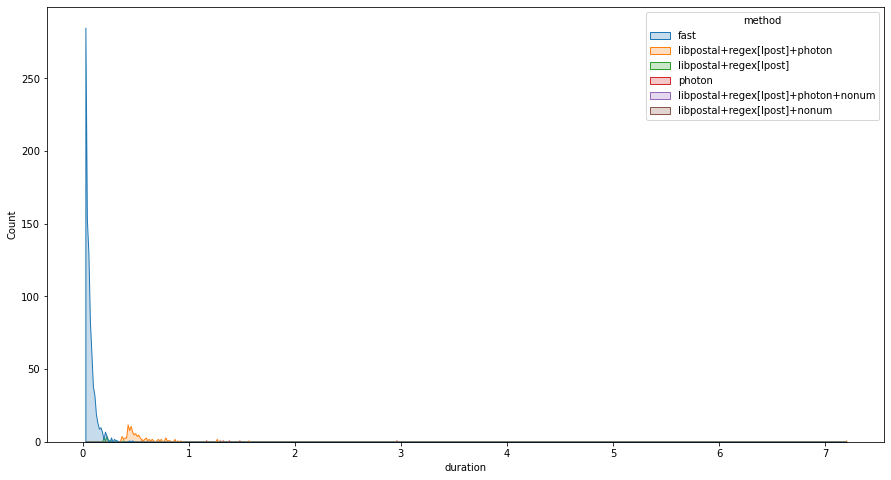

In [76]:
nw = geocoded_data[geocoded_data.geocoder=="nominatim_wrapper"]
nw = nw.assign(method=nw.location.apply(lambda x:x.raw["metadata"]["method"]))
plt.figure(figsize=(15,8))
g =sbn.histplot(nw, x="duration", hue="method", element="poly")
# g.set_yscale('log')

# nw

<AxesSubplot:>

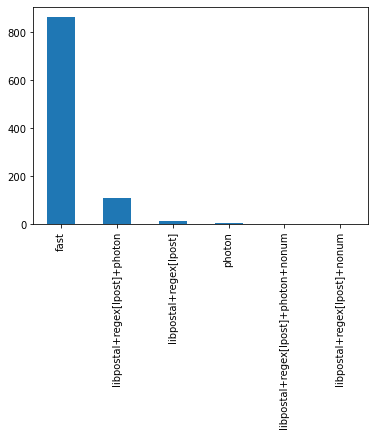

In [77]:
nw.method.value_counts().plot.bar()

<AxesSubplot:xlabel='method'>

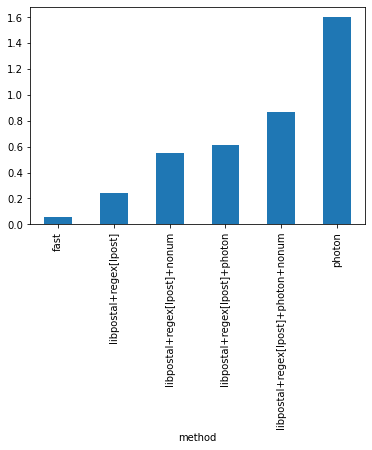

In [78]:
# sbn.barplot(nw.groupby("method").address.count().reset_index(), x="method", y="address")
nw.groupby("method").duration.mean().plot.bar()

## Extract precision

In [184]:
geocoded_data["precision"] = geocoded_data.apply(get_precision, axis=1)

In [185]:
geocoded_data[geocoded_data.precision.str.contains("UNK")][["geocoder" , "precision"]].value_counts()#drop_duplicates()

geocoder  precision                   
mapbox    [UNKNOWN]                       32
bing      [UNKNOWN - RoadIntersection]     1
dtype: int64

In [186]:
geocoded_data["precision"] = geocoded_data.precision.replace("^\[UNKNOWN.*\]", "[UNKNOWN]", regex=True)

In [187]:
# geocoded_data[geocoded_data.precision== "[UNKNOWN - APPROXIMATE]"].iloc[-1].location.raw

In [188]:
# geocoded_data[geocoded_data.precision== "[UNKNOWN - APPROXIMATE]"]

In [189]:
# geocoded_data.loc[599].location.raw#["entityType"]

In [190]:
# geocoders["mapbox"].geocode("2627 Schelle").raw

In [191]:
lat = geocoded_data["location"].apply(lambda loc: loc.point.latitude if loc else None)
lng =  geocoded_data["location"].apply(lambda loc: loc.point.longitude if loc else None)
geocoded_data["point"] = np.where(lat.notnull(), gpd.points_from_xy(lng, lat), pd.NA)

/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


In [192]:
geocoded_data

street housenumber postcode             city  \
0            de Burburelaan          46     1970  Wezembeek-Oppem   
1           Nachtegalenlaan          35     1950         Kraainem   
2             Rue Tilia(ST)          12     6511         Beaumont   
3            Rue du Hock(N)          36     4121           Neupré   
4           Wuustwezelseweg          95     2990       Wuustwezel   
...                     ...         ...      ...              ...   
6845  Vlasbloemstraat(Woes)           6     8640         Vleteren   
6846              Abtsdreef         259     2940         Stabroek   
6847        Rue des Chalets           5     4030            Liège   
6848             Lichterweg           3     2030        Antwerpen   
6849       Grote Markt(Kor)          41     8500         Kortrijk   

                                                address  \
0     de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1          Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2            Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3             Rue du Hock(N), 36, 4121 Neupré, Belgique   
4        Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
...                                                 ...   
6845  Vlasbloemstraat(Woes), 6, 8640 Vleteren, Belgique   
6846            Abtsdreef, 259, 2940 Stabroek, Belgique   
6847           Rue des Chalets, 5, 4030 Liège, Belgique   
6848            Lichterweg, 3, 2030 Antwerpen, Belgique   
6849      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   

                                               location           geocoder  \
0     (Oscar de Burburelaan, Wezembeek, Wezembeek-Op...  nominatim_wrapper   
1     (35, Nachtegalenlaan, Kraainem, Halle-Vilvoord...  nominatim_wrapper   
2     (Rue Tilia, Strée, Beaumont, Thuin, Hainaut, W...  nominatim_wrapper   
3     (36, Rue du Hock, Neuville-en-Condroz, Neupré,...  nominatim_wrapper   
4     (95, Wuustwezelseweg, Loenhout, Wuustwezel, An...  nominatim_wrapper   
...                                                 ...                ...   
6845  (Vlasbloemstraat, 8640 Vleteren, Belgium, (50....             google   
6846  (Abtsdreef 259, 2940 Stabroek, Belgium, (51.34...             google   
6847  (Rue des Chalets 5, 4030 Liège, Belgium, (50.6...             google   
6848  (Lichterweg 3, 2030 Antwerpen, Belgium, (51.24...             google   
6849        (Kortrijk, Belgium, (50.826806, 3.2543899))             google   

      duration precision                     point  is_in_belgium  \
0     0.141377    street  POINT (4.48043 50.85266)           True   
1     0.092073  building  POINT (4.47192 50.85666)           True   
2     0.053527    street  POINT (4.30095 50.27056)           True   
3     0.089439  building  POINT (5.45565 50.55351)           True   
4     0.142177  building  POINT (4.62704 51.40046)           True   
...        ...       ...                       ...            ...   
6845  0.094116    street  POINT (2.79721 50.90958)           True   
6846  0.112655  building  POINT (4.34698 51.34361)           True   
6847  0.095659  building  POINT (5.59088 50.62815)           True   
6848  0.092238  building  POINT (4.38870 51.24911)           True   
6849  0.086812      city  POINT (3.25439 50.82681)           True   

                        median_point  nb_points dist_to_median  \
0     POINT (498587.754 6595071.625)        5.0     263.973868   
1     POINT (497812.970 6595975.832)        5.0       1.455976   
2     POINT (479073.247 6493719.741)        4.0     541.163092   
3     POINT (607319.000 6542691.616)        4.0       1.044688   
4     POINT (515081.618 6692445.348)        5.0       7.499792   
...                              ...        ...            ...   
6845  POINT (311045.582 6605752.872)        3.0     553.601038   
6846  POINT (483910.279 6682261.698)        5.0      39.352295   
6847  POINT (622375.696 6555779.311)        5.0       1.659032   
6848                            None        NaN          

In [266]:
geocoded_data = gpd.GeoDataFrame(geocoded_data).set_geometry("point").set_crs(osm_crs, allow_override=True).to_crs(crs)
geocoded_data

street housenumber postcode             city  \
0            de Burburelaan          46     1970  Wezembeek-Oppem   
1           Nachtegalenlaan          35     1950         Kraainem   
2             Rue Tilia(ST)          12     6511         Beaumont   
3            Rue du Hock(N)          36     4121           Neupré   
4           Wuustwezelseweg          95     2990       Wuustwezel   
...                     ...         ...      ...              ...   
6845  Vlasbloemstraat(Woes)           6     8640         Vleteren   
6846              Abtsdreef         259     2940         Stabroek   
6847        Rue des Chalets           5     4030            Liège   
6848             Lichterweg           3     2030        Antwerpen   
6849       Grote Markt(Kor)          41     8500         Kortrijk   

                                                address  \
0     de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1          Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2            Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3             Rue du Hock(N), 36, 4121 Neupré, Belgique   
4        Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
...                                                 ...   
6845  Vlasbloemstraat(Woes), 6, 8640 Vleteren, Belgique   
6846            Abtsdreef, 259, 2940 Stabroek, Belgique   
6847           Rue des Chalets, 5, 4030 Liège, Belgique   
6848            Lichterweg, 3, 2030 Antwerpen, Belgique   
6849      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   

                                               location           geocoder  \
0     (Oscar de Burburelaan, Wezembeek, Wezembeek-Op...  nominatim_wrapper   
1     (35, Nachtegalenlaan, Kraainem, Halle-Vilvoord...  nominatim_wrapper   
2     (Rue Tilia, Strée, Beaumont, Thuin, Hainaut, W...  nominatim_wrapper   
3     (36, Rue du Hock, Neuville-en-Condroz, Neupré,...  nominatim_wrapper   
4     (95, Wuustwezelseweg, Loenhout, Wuustwezel, An...  nominatim_wrapper   
...                                                 ...                ...   
6845  (Vlasbloemstraat, 8640 Vleteren, Belgium, (50....             google   
6846  (Abtsdreef 259, 2940 Stabroek, Belgium, (51.34...             google   
6847  (Rue des Chalets 5, 4030 Liège, Belgium, (50.6...             google   
6848  (Lichterweg 3, 2030 Antwerpen, Belgium, (51.24...             google   
6849        (Kortrijk, Belgium, (50.826806, 3.2543899))             google   

      duration precision                           point  is_in_belgium  \
0     0.141377    street  POINT (498759.064 6595272.461)          False   
1     0.092073  building  POINT (497811.825 6595976.732)          False   
2     0.053527    street  POINT (478780.031 6493264.898)          False   
3     0.089439  building  POINT (607319.913 6542692.124)          False   
4     0.142177  building  POINT (515079.967 6692438.032)          False   
...        ...       ...                             ...            ...   
6845  0.094116    street  POINT (311383.648 6605314.483)          False   
6846  0.112655  building  POINT (483904.123 6682300.566)          False   
6847  0.095659  building  POINT (622374.037 6555779.276)          False   
6848  0.092238  building  POINT (488547.359 6665477.309)          False   
6849  0.086812      city  POINT (362277.027 6590714.701)          False   

                        median_point  nb_points  dist_to_median  \
0     POINT (498587.754 6595071.625)        5.0  6613840.356654   
1     POINT (497812.970 6595975.832)        5.0  6614683.634649   
2     POINT (479073.247 6493719.741)        4.0   6511317.08981   
3     POINT (607319.000 6542691.616)        4.0  6570767.216695   
4     POINT (515081.618 6692445.348)        5.0  6712186.011642   
...                              ...        ...             ...   
6845  POINT (311045.582 6605752.872)        3.0  6613020.945867   
6846  POINT (483910.279 6682261.698)        5.0  6699708.961422   
6847  POINT (622375.696 6555779.311)      

In [267]:
geocoded_data

street housenumber postcode             city  \
0            de Burburelaan          46     1970  Wezembeek-Oppem   
1           Nachtegalenlaan          35     1950         Kraainem   
2             Rue Tilia(ST)          12     6511         Beaumont   
3            Rue du Hock(N)          36     4121           Neupré   
4           Wuustwezelseweg          95     2990       Wuustwezel   
...                     ...         ...      ...              ...   
6845  Vlasbloemstraat(Woes)           6     8640         Vleteren   
6846              Abtsdreef         259     2940         Stabroek   
6847        Rue des Chalets           5     4030            Liège   
6848             Lichterweg           3     2030        Antwerpen   
6849       Grote Markt(Kor)          41     8500         Kortrijk   

                                                address  \
0     de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1          Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2            Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3             Rue du Hock(N), 36, 4121 Neupré, Belgique   
4        Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
...                                                 ...   
6845  Vlasbloemstraat(Woes), 6, 8640 Vleteren, Belgique   
6846            Abtsdreef, 259, 2940 Stabroek, Belgique   
6847           Rue des Chalets, 5, 4030 Liège, Belgique   
6848            Lichterweg, 3, 2030 Antwerpen, Belgique   
6849      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   

                                               location           geocoder  \
0     (Oscar de Burburelaan, Wezembeek, Wezembeek-Op...  nominatim_wrapper   
1     (35, Nachtegalenlaan, Kraainem, Halle-Vilvoord...  nominatim_wrapper   
2     (Rue Tilia, Strée, Beaumont, Thuin, Hainaut, W...  nominatim_wrapper   
3     (36, Rue du Hock, Neuville-en-Condroz, Neupré,...  nominatim_wrapper   
4     (95, Wuustwezelseweg, Loenhout, Wuustwezel, An...  nominatim_wrapper   
...                                                 ...                ...   
6845  (Vlasbloemstraat, 8640 Vleteren, Belgium, (50....             google   
6846  (Abtsdreef 259, 2940 Stabroek, Belgium, (51.34...             google   
6847  (Rue des Chalets 5, 4030 Liège, Belgium, (50.6...             google   
6848  (Lichterweg 3, 2030 Antwerpen, Belgium, (51.24...             google   
6849        (Kortrijk, Belgium, (50.826806, 3.2543899))             google   

      duration precision                           point  is_in_belgium  \
0     0.141377    street  POINT (498759.064 6595272.461)          False   
1     0.092073  building  POINT (497811.825 6595976.732)          False   
2     0.053527    street  POINT (478780.031 6493264.898)          False   
3     0.089439  building  POINT (607319.913 6542692.124)          False   
4     0.142177  building  POINT (515079.967 6692438.032)          False   
...        ...       ...                             ...            ...   
6845  0.094116    street  POINT (311383.648 6605314.483)          False   
6846  0.112655  building  POINT (483904.123 6682300.566)          False   
6847  0.095659  building  POINT (622374.037 6555779.276)          False   
6848  0.092238  building  POINT (488547.359 6665477.309)          False   
6849  0.086812      city  POINT (362277.027 6590714.701)          False   

                        median_point  nb_points  dist_to_median  \
0     POINT (498587.754 6595071.625)        5.0  6613840.356654   
1     POINT (497812.970 6595975.832)        5.0  6614683.634649   
2     POINT (479073.247 6493719.741)        4.0   6511317.08981   
3     POINT (607319.000 6542691.616)        4.0  6570767.216695   
4     POINT (515081.618 6692445.348)        5.0  6712186.011642   
...                              ...        ...             ...   
6845  POINT (311045.582 6605752.872)        3.0  6613020.945867   
6846  POINT (483910.279 6682261.698)        5.0  6699708.961422   
6847  POINT (622375.696 6555779.311)      

In [268]:
# geocoded_data = geocoded_data.append(trillium[["address", "geocoder", "precision"]])

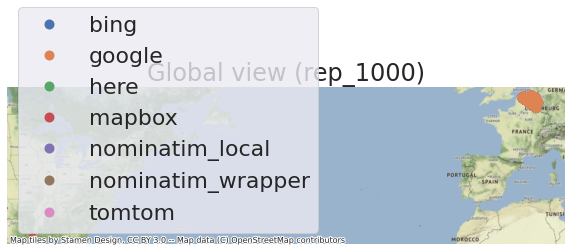

In [269]:
from matplotlib.colors import ListedColormap

colors = ListedColormap([f"C{i}" for i in range(geocoded_data.geocoder.nunique())], name="mycmap")
ax=geocoded_data[geocoded_data.geocoder != "trillium"].plot("geocoder", legend=True, figsize=(10,15), cmap=colors)
plt.title(f"Global view ({ds})")
add_basemap(ax)
# img_name=f"{fig_path}/global_{dataset}.png"
# plt.savefig(img_name,  bbox_inches='tight')
# pdf_add_image(pdf, img_name)
# pdf.add_page()
# pdf.image(f"{fig_path}/global_{dataset}.png", 0, 0, 290)
plt.axis("off")
pdf.savefig( bbox_inches='tight')
# plt.show()
# plt.close()


In [270]:
belgium_boundaries = gpd.read_file("data/boundaries.geojson", driver="GeoJSON")
belgium_boundaries = belgium_boundaries[belgium_boundaries.name == "BEL"].geometry.iloc[0].simplify(1000).buffer(1000)
# belgium_boundaries

In [274]:
# belgium_boundaries

In [275]:
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# ax = world.to_crs(crs).plot()
# gpd.GeoSeries({"geometry": shapely.geometry.Point(0,0)}).plot(ax=ax, color="red")
# plt.ylim([-10000000, 12000000])
# plt.axis("off")

In [276]:
# ax = gpd.GeoSeries({"geometry": belgium_boundaries}).plot()
# gpd.GeoSeries({"geometry": shapely.geometry.Point(0,0)}).set_crs("EPSG:31370").to_crs(crs).plot(ax=ax, color="red")
# plt.axis("off")

In [277]:
geocoded_data["is_in_belgium"]= geocoded_data.geometry.within(belgium_boundaries)
geocoded_data["is_in_belgium"].value_counts()

True     6847
False       3
Name: is_in_belgium, dtype: int64

In [278]:
geocoded_data.groupby("geocoder").is_in_belgium.value_counts()

geocoder           is_in_belgium
bing               True             1000
google             True             1000
here               True             1000
mapbox             True              997
                   False               3
nominatim_local    True              863
nominatim_wrapper  True              994
tomtom             True              993
Name: is_in_belgium, dtype: int64

In [279]:
geocoded_data

street housenumber postcode             city  \
0            de Burburelaan          46     1970  Wezembeek-Oppem   
1           Nachtegalenlaan          35     1950         Kraainem   
2             Rue Tilia(ST)          12     6511         Beaumont   
3            Rue du Hock(N)          36     4121           Neupré   
4           Wuustwezelseweg          95     2990       Wuustwezel   
...                     ...         ...      ...              ...   
6845  Vlasbloemstraat(Woes)           6     8640         Vleteren   
6846              Abtsdreef         259     2940         Stabroek   
6847        Rue des Chalets           5     4030            Liège   
6848             Lichterweg           3     2030        Antwerpen   
6849       Grote Markt(Kor)          41     8500         Kortrijk   

                                                address  \
0     de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1          Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2            Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3             Rue du Hock(N), 36, 4121 Neupré, Belgique   
4        Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
...                                                 ...   
6845  Vlasbloemstraat(Woes), 6, 8640 Vleteren, Belgique   
6846            Abtsdreef, 259, 2940 Stabroek, Belgique   
6847           Rue des Chalets, 5, 4030 Liège, Belgique   
6848            Lichterweg, 3, 2030 Antwerpen, Belgique   
6849      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   

                                               location           geocoder  \
0     (Oscar de Burburelaan, Wezembeek, Wezembeek-Op...  nominatim_wrapper   
1     (35, Nachtegalenlaan, Kraainem, Halle-Vilvoord...  nominatim_wrapper   
2     (Rue Tilia, Strée, Beaumont, Thuin, Hainaut, W...  nominatim_wrapper   
3     (36, Rue du Hock, Neuville-en-Condroz, Neupré,...  nominatim_wrapper   
4     (95, Wuustwezelseweg, Loenhout, Wuustwezel, An...  nominatim_wrapper   
...                                                 ...                ...   
6845  (Vlasbloemstraat, 8640 Vleteren, Belgium, (50....             google   
6846  (Abtsdreef 259, 2940 Stabroek, Belgium, (51.34...             google   
6847  (Rue des Chalets 5, 4030 Liège, Belgium, (50.6...             google   
6848  (Lichterweg 3, 2030 Antwerpen, Belgium, (51.24...             google   
6849        (Kortrijk, Belgium, (50.826806, 3.2543899))             google   

      duration precision                           point  is_in_belgium  \
0     0.141377    street  POINT (498759.064 6595272.461)           True   
1     0.092073  building  POINT (497811.825 6595976.732)           True   
2     0.053527    street  POINT (478780.031 6493264.898)           True   
3     0.089439  building  POINT (607319.913 6542692.124)           True   
4     0.142177  building  POINT (515079.967 6692438.032)           True   
...        ...       ...                             ...            ...   
6845  0.094116    street  POINT (311383.648 6605314.483)           True   
6846  0.112655  building  POINT (483904.123 6682300.566)           True   
6847  0.095659  building  POINT (622374.037 6555779.276)           True   
6848  0.092238  building  POINT (488547.359 6665477.309)           True   
6849  0.086812      city  POINT (362277.027 6590714.701)           True   

                        median_point  nb_points  dist_to_median  \
0     POINT (498587.754 6595071.625)        5.0  6613840.356654   
1     POINT (497812.970 6595975.832)        5.0  6614683.634649   
2     POINT (479073.247 6493719.741)        4.0   6511317.08981   
3     POINT (607319.000 6542691.616)        4.0  6570767.216695   
4     POINT (515081.618 6692445.348)        5.0  6712186.011642   
...                              ...        ...             ...   
6845  POINT (311045.582 6605752.872)        3.0  6613020.945867   
6846  POINT (483910.279 6682261.698)        5.0  6699708.961422   
6847  POINT (622375.696 6555779.311)      

In [280]:
geocoded_data[~geocoded_data.is_in_belgium & (geocoded_data.geocoder!= "trillium") ]

street housenumber postcode             city  \
4111           Rue des Rivaux(L.L)           2     7100      La Louvière   
4483             Rue de Baume(L.L)         377     7100      La Louvière   
4843  Rue de la Giloterie,Vitrival          28     5070  Fosses-la-Ville   

                                                address  \
4111  Rue des Rivaux(L.L), 2, 7100 La Louvière, Belg...   
4483  Rue de Baume(L.L), 377, 7100 La Louvière, Belg...   
4843  Rue de la Giloterie,Vitrival, 28, 5070 Fosses-...   

                                               location geocoder  duration  \
4111  (Louisiana, United States, (30.9374993015932, ...   mapbox  0.181678   
4483  (Louisiana, United States, (30.9374993015932, ...   mapbox  0.168161   
4843  (Louisiana, United States, (30.9374993015932, ...   mapbox  0.174292   

      precision                              point  is_in_belgium  \
4111  [UNKNOWN]  POINT (-10275456.702 3624634.895)          False   
4483  [UNKNOWN]  POINT (-10275456.702 3624634.895)          False   
4843  [UNKNOWN]  POINT (-10275456.702 3624634.895)          False   

                        median_point  nb_points  dist_to_median  \
4111                            None        NaN             NaN   
4483                            None        NaN             NaN   
4843  POINT (516581.437 6514995.681)        4.0  6535420.213536   

      nb_close_to_median  has_median  is_value_normal  less_than_10km  \
4111                 NaN       False            False           False   
4483                 NaN       False            False           False   
4843                 5.0        True             True           False   

      is_below_top_whisker  is_reliable  
4111                 False        False  
4483                 False        False  
4843                  True        False

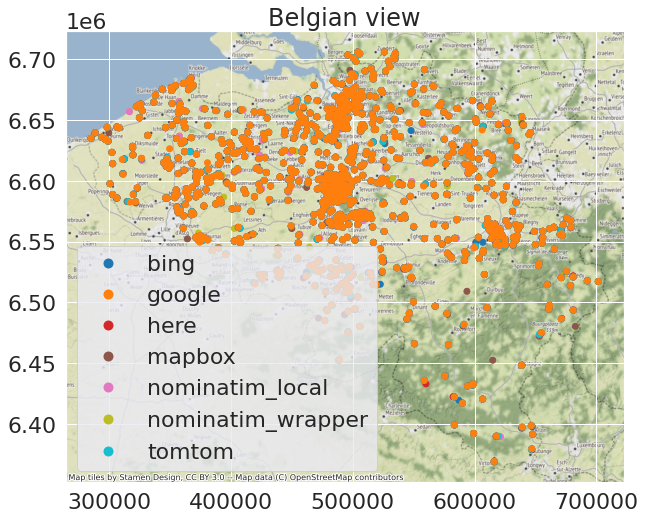

In [281]:
ax=geocoded_data[geocoded_data.is_in_belgium].plot("geocoder", legend=True, figsize=(10,15))
plt.title("Belgian view")
add_basemap(ax)
# img_name=f"{fig_path}/belgium_{dataset}.png"
# plt.savefig(img_name,  bbox_inches='tight')
# pdf_add_image(pdf, img_name, width=240)
pdf.savefig(bbox_inches='tight')
# plt.show()
# plt.close()


## Compute (distance to) median

In [282]:
def get_median_point(bloc):
    bloc = gpd.GeoSeries(bloc.dropna())
    x = np.median(bloc.x)
    y = np.median(bloc.y)
    return shapely.geometry.Point(x, y), bloc.shape[0]
 

In [283]:
median_geocoders = ["here", "bing", "mapbox", "tomtom", "nominatim_wrapper", "google", "bestaddress"] # Median based on those geocoders
median_points = geocoded_data[geocoded_data.geocoder.isin(median_geocoders)&( geocoded_data.precision=="building") ].groupby("address").point.apply(get_median_point).apply(pd.Series)#.rename("median_point").reset_index()
median_points = median_points.rename(columns={0: "median_point", 1: "nb_points"}).reset_index()
median_points = median_points.set_geometry("median_point").set_crs(geocoded_data.crs)
median_points

/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


address  \
0               't Vlietje, 4, 2800 Mechelen, Belgique   
1        Aalstersesteenweg, 362, 9400 Ninove, Belgique   
2         Aaltersesteenweg, 122, 9800 Deinze, Belgique   
3        Aarschotsesteenweg, 22, 3012 Leuven, Belgique   
4    Aarschotsesteenweg, 54A, 3110 Rotselaar, Belgique   
..                                                 ...   
992  de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
993  de Limburg Stirumlaan, 100, 1780 Wemmel, Belgique   
994  de Smet de Naeyerlaan, 526, 1020 Brussel, Belg...   
995   rue des Maraîchers, 9, 1070 Anderlecht, Belgique   
996           rue du Chenia, 15, 7170 Manage, Belgique   

                       median_point  nb_points  
0    POINT (499196.315 6626069.331)          6  
1    POINT (449065.119 6596429.049)          5  
2    POINT (389868.103 6620321.889)          6  
3    POINT (524091.923 6601928.128)          6  
4    POINT (527891.497 6611051.200)          5  
..                              ...        ...  
992  POINT (498587.754 6595071.625)          5  
993  POINT (480158.345 6604332.636)          5  
994  POINT (483041.653 6600914.669)          5  
995  POINT (478803.603 6592983.817)          6  
996  POINT (472189.450 6534709.857)          3  

[997 rows x 3 columns]

<AxesSubplot:ylabel='nb_points'>

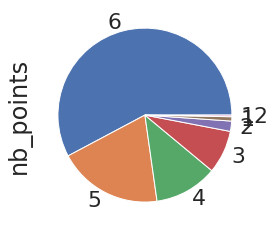

In [284]:
median_points.nb_points.value_counts().plot.pie()

In [285]:
median_points = median_points[median_points.nb_points >= 3]
median_points.shape

(970, 3)

In [286]:
geocoded_data = geocoded_data.merge(median_points, how="left")#.dropna()
# geocoded_data

In [287]:
geocoded_data["dist_to_median"] = geocoded_data.point.distance(geocoded_data.median_point.set_crs(geocoded_data.crs))
geocoded_data.sort_values("dist_to_median")#.tail(100)

street housenumber postcode                city  \
5064                 Rue des Ailes          60     1030          Schaerbeek   
4914          Le Brûlis,Tontelange         196     6717              Attert   
2498                      Veemarkt          19     2800            Mechelen   
4909                         Markt          50     9160             Lokeren   
4908            Rue Joseph Wauters         3 B     4500                 Huy   
...                            ...         ...      ...                 ...   
6597      Avenue Reine Astrid(W-B)          16     1440   Braine-le-Château   
6619                     Zandvoort          10     2030           Antwerpen   
6772  Rue Isidore-Derèse,Mornimont         155     5190  Jemeppe-sur-Sambre   
6791              Rue de Lassus(H)          46     7712            Mouscron   
6848                    Lichterweg           3     2030           Antwerpen   

                                                address  \
5064       Rue des Ailes, 60, 1030 Schaerbeek, Belgique   
4914   Le Brûlis,Tontelange, 196, 6717 Attert, Belgique   
2498              Veemarkt, 19, 2800 Mechelen, Belgique   
4909                  Markt, 50, 9160 Lokeren, Belgique   
4908        Rue Joseph Wauters, 3 B, 4500 Huy, Belgique   
...                                                 ...   
6597  Avenue Reine Astrid(W-B), 16, 1440 Braine-le-C...   
6619            Zandvoort, 10, 2030 Antwerpen, Belgique   
6772  Rue Isidore-Derèse,Mornimont, 155, 5190 Jemepp...   
6791      Rue de Lassus(H), 46, 7712 Mouscron, Belgique   
6848            Lichterweg, 3, 2030 Antwerpen, Belgique   

                                               location geocoder  duration  \
5064  (Rue des Ailes 60, 1030 Bruxelles, (50.86867, ...   tomtom  0.136517   
4914  (Le Brûlis 196, 6717 Attert, (49.72495, 5.80878))   tomtom  0.118642   
2498  (Veemarkt 19, 2800 Mechelen, België, Mechelen,...     here  0.045298   
4909      (Markt 50, 9160 Lokeren, (51.10363, 3.99192))   tomtom  0.112250   
4908  (Rue Joseph Wauters 3, 4500 Huy, (50.52295, 5....   tomtom  0.037420   
...                                                 ...      ...       ...   
6597  (Av. Reine Astrid, 1440, Belgium, (50.6886599,...   google  0.125471   
6619  (Zandvoort, 2030 Antwerpen, Belgium, (51.27142...   google  0.085460   
6772  (Rue Isidore Derèse 155, 5190 Jemeppe-sur-Samb...   google  0.112417   
6791  (Rue de Lassus, 7712 Mouscron, Belgium, (50.71...   google  0.136508   
6848  (Lichterweg 3, 2030 Antwerpen, Belgium, (51.24...   google  0.092238   

     precision                           point  is_in_belgium  \
5064  building  POINT (487012.753 6598095.762)           True   
4914  building  POINT (646630.432 6398777.585)           True   
2498  building  POINT (499145.465 6626455.181)           True   
4909  building  POINT (444378.502 6639645.182)           True   
4908  building  POINT (580956.385 6537339.003)           True   
...        ...                             ...            ...   
6597    street  POINT (481171.241 6566404.949)           True   
6619    street  POINT (485922.646 6669446.046)           True   
6772  building  POINT (524259.209 6525478.475)           True   
6791    street  POINT (361051.733 6571240.027)           True   
6848  building  POINT (488547.359 6665477.309)           True   

                        median_point  nb_points  dist_to_median  \
5064  POINT (487012.753 6598095.762)        5.0             0.0   
4914  POINT (646630.432 6398777.585)        3.0             0.0   
2498  POINT (499145.465 6626455.181)        5.0             0.0   
4909  POINT (444378.502 6639645.182)        5.0             0.0   
4908  POINT (580956.385 6537339.003)        5.0             0.0   
...                              ...        ...             ...   
6597                            None        NaN             NaN   
6619                            None        NaN             NaN   
6772                            None        NaN  

In [288]:
geocoded_data[geocoded_data.median_point.isnull()].sort_values("address")

street housenumber postcode       city  \
2130  Allée J.F. Kennedy(Cha)           8     5650   Walcourt   
6123  Allée J.F. Kennedy(Cha)           8     5650   Walcourt   
5128  Allée J.F. Kennedy(Cha)           8     5650   Walcourt   
3130  Allée J.F. Kennedy(Cha)           8     5650   Walcourt   
272   Allée J.F. Kennedy(Cha)           8     5650   Walcourt   
...                       ...         ...      ...        ...   
1662                Zandvoort          10     2030  Antwerpen   
5620                Zandvoort          10     2030  Antwerpen   
3626                Zandvoort          10     2030  Antwerpen   
765                 Zandvoort          10     2030  Antwerpen   
6619                Zandvoort          10     2030  Antwerpen   

                                                address  \
2130  Allée J.F. Kennedy(Cha), 8, 5650 Walcourt, Bel...   
6123  Allée J.F. Kennedy(Cha), 8, 5650 Walcourt, Bel...   
5128  Allée J.F. Kennedy(Cha), 8, 5650 Walcourt, Bel...   
3130  Allée J.F. Kennedy(Cha), 8, 5650 Walcourt, Bel...   
272   Allée J.F. Kennedy(Cha), 8, 5650 Walcourt, Bel...   
...                                                 ...   
1662            Zandvoort, 10, 2030 Antwerpen, Belgique   
5620            Zandvoort, 10, 2030 Antwerpen, Belgique   
3626            Zandvoort, 10, 2030 Antwerpen, Belgique   
765             Zandvoort, 10, 2030 Antwerpen, Belgique   
6619            Zandvoort, 10, 2030 Antwerpen, Belgique   

                                               location           geocoder  \
2130  (Allée John F. Kennedy 7, 5650 Walcourt, Belgi...               here   
6123  (Allée J. F. Kennedy, 5650 Walcourt, Belgium, ...             google   
5128  (Allée John Fitzgerald Kennedy 8, 5650 Walcour...             tomtom   
3130  (Walcourt, Walloon Region 5650, Belgium, (50.2...               bing   
272   (Allée John-Fitzgerald Kennedy, Chastrès, Walc...  nominatim_wrapper   
...                                                 ...                ...   
1662  (Zandvoort, Antwerpen, Vlaanderen, 2030, Belgi...    nominatim_local   
5620  (Zandvoort 10, 2000 Antwerpen, (51.27462, 4.35...             tomtom   
3626  (Zandvoort 10, Westerlo, Flemish Region 2260, ...               bing   
765   (Zandvoort, Antwerpen, Vlaanderen, 2030, Belgi...  nominatim_wrapper   
6619  (Zandvoort, 2030 Antwerpen, Belgium, (51.27142...             google   

      duration precision                           point  is_in_belgium  \
2130  0.069293  building  POINT (496219.810 6492823.768)           True   
6123  0.125793    street  POINT (496210.593 6492846.060)           True   
5128  0.186127  building  POINT (496296.799 6492797.837)           True   
3130  0.178192      city  POINT (493333.499 6489985.378)           True   
272   0.512705    street  POINT (496191.090 6492838.067)           True   
...        ...       ...                             ...            ...   
1662  0.024546    street  POINT (486304.672 6669142.466)           True   
5620  0.150797    street  POINT (485187.114 6670015.340)           True   
3626  0.214655  building  POINT (547838.480 6641229.693)           True   
765   0.114914    street  POINT (486304.672 6669142.466)           True   
6619  0.085460    street  POINT (485922.646 6669446.046)           True   

     median_point  nb_points  dist_to_median  nb_close_to_median  has_median  \
2130         None        NaN             NaN                 NaN       False   
6123         None        NaN             NaN                 NaN       False   
5128         None        NaN             NaN                 NaN       False   
3130         None        NaN             NaN                 NaN       False   
272          None        NaN             NaN                 NaN       False   
...           ...        ...             ...                 ...         ...   
1662         None        NaN             NaN                 NaN       False   
5620         None        NaN             NaN           

In [289]:
# geocoded_data.sort_values("dist_to_median").tail(40).geocoder.value_counts().plot.bar()

In [290]:
def plot_address(geocoded_data, a):
    df = geocoded_data[(geocoded_data.address==a)& (geocoded_data.geocoder != "trillium")]
    display(df)
    

    ax = df.assign(label=df.geocoder + " ("+df.dist_to_median.fillna(-1).astype(int).astype(str) + " - " + df.precision + ")").plot(
        "label", 
        legend=True, 
        markersize=100,
            figsize=(10,12)
    )

    if df.dist_to_median.isnull().all():
        print("No median point")
    else: 
        med=df[["median_point"]].drop_duplicates().set_geometry("median_point")
                                                                                                                         
        med.plot(ax=ax, color="red", marker="x", markersize=100)
    ax.set_title(a)
    set_optimal_limits(ax, df)
    add_basemap(ax)
    plt.show()    
    return ax

street housenumber postcode      city  \
7     Torhoutsesteenweg          66     8210  Zedelgem   
1001  Torhoutsesteenweg          66     8210  Zedelgem   
1864  Torhoutsesteenweg          66     8210  Zedelgem   
2864  Torhoutsesteenweg          66     8210  Zedelgem   
3864  Torhoutsesteenweg          66     8210  Zedelgem   
4864  Torhoutsesteenweg          66     8210  Zedelgem   
5857  Torhoutsesteenweg          66     8210  Zedelgem   

                                             address  \
7     Torhoutsesteenweg, 66, 8210 Zedelgem, Belgique   
1001  Torhoutsesteenweg, 66, 8210 Zedelgem, Belgique   
1864  Torhoutsesteenweg, 66, 8210 Zedelgem, Belgique   
2864  Torhoutsesteenweg, 66, 8210 Zedelgem, Belgique   
3864  Torhoutsesteenweg, 66, 8210 Zedelgem, Belgique   
4864  Torhoutsesteenweg, 66, 8210 Zedelgem, Belgique   
5857  Torhoutsesteenweg, 66, 8210 Zedelgem, Belgique   

                                               location           geocoder  \
7     (Fleur de Lys, 66, Torhoutsesteenweg, Zuidwege...  nominatim_wrapper   
1001  (Fleur de Lys, 66, Torhoutsesteenweg, Zuidwege...    nominatim_local   
1864  (Torhoutsesteenweg 66, 8210 Zedelgem, België, ...               here   
2864  (Torhoutsesteenweg 66, Zedelgem, Flemish Regio...               bing   
3864  (Torhoutsesteenweg 66, 8210 Zedelgem, West Fla...             mapbox   
4864  (Torhoutsesteenweg 66, 8210 Zedelgem, (51.1381...             tomtom   
5857  (Torhoutsesteenweg 66, 8210 Zedelgem, Belgium,...             google   

      duration precision                           point  is_in_belgium  \
7     0.150389  building  POINT (351696.072 6645769.163)           True   
1001  0.015702  building  POINT (351696.072 6645769.163)           True   
1864  0.060347  building  POINT (351695.007 6645770.884)           True   
2864  0.222266  building  POINT (351695.018 6645769.110)           True   
3864  0.322474  building  POINT (351695.675 6645770.174)           True   
4864  0.096180  building  POINT (351695.007 6645769.110)           True   
5857  0.143880  building  POINT (351695.207 6645761.339)           True   

                        median_point  nb_points  dist_to_median  \
7     POINT (351695.018 6645769.110)        5.0        1.055267   
1001  POINT (351695.018 6645769.110)        5.0        1.055267   
1864  POINT (351695.018 6645769.110)        5.0        1.774208   
2864  POINT (351695.018 6645769.110)        5.0        0.000000   
3864  POINT (351695.018 6645769.110)        5.0        1.250813   
4864  POINT (351695.018 6645769.110)        5.0        0.011132   
5857  POINT (351695.018 6645769.110)        5.0        7.773176   

      nb_close_to_median  has_median  is_value_normal  less_than_10km  \
7                    7.0        True             True           False   
1001                 7.0        True             True           False   
1864                 7.0        True             True           False   
2864                 7.0        True             True           False   
3864                 7.0        True             True           False   
4864                 7.0        True             True           False   
5857                 7.0        True             True           False   

      is_below_top_whisker  is_reliable  
7                     True        False  
1001                  True        False  
1864                  True        False  
2864                  True        False  
3864                  True        False  
4864                  True        False  
5857                  True        False

/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)
/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


Default basemap doesn't work...


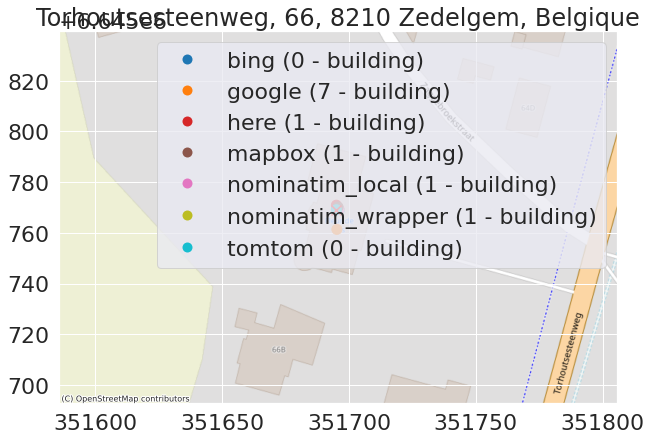

<AxesSubplot:title={'center':'Torhoutsesteenweg, 66, 8210 Zedelgem, Belgique'}>

In [291]:
plot_address(geocoded_data, geocoded_data.iloc[7].address)

street housenumber postcode             city  \
981   Rue de la Giloterie,Vitrival          28     5070  Fosses-la-Ville   
1850  Rue de la Giloterie,Vitrival          28     5070  Fosses-la-Ville   
2843  Rue de la Giloterie,Vitrival          28     5070  Fosses-la-Ville   
3843  Rue de la Giloterie,Vitrival          28     5070  Fosses-la-Ville   
4843  Rue de la Giloterie,Vitrival          28     5070  Fosses-la-Ville   
5836  Rue de la Giloterie,Vitrival          28     5070  Fosses-la-Ville   
6836  Rue de la Giloterie,Vitrival          28     5070  Fosses-la-Ville   

                                                address  \
981   Rue de la Giloterie,Vitrival, 28, 5070 Fosses-...   
1850  Rue de la Giloterie,Vitrival, 28, 5070 Fosses-...   
2843  Rue de la Giloterie,Vitrival, 28, 5070 Fosses-...   
3843  Rue de la Giloterie,Vitrival, 28, 5070 Fosses-...   
4843  Rue de la Giloterie,Vitrival, 28, 5070 Fosses-...   
5836  Rue de la Giloterie,Vitrival, 28, 5070 Fosses-...   
6836  Rue de la Giloterie,Vitrival, 28, 5070 Fosses-...   

                                               location           geocoder  \
981   (28, Rue de la Giloterie, Le Roux, Fosses-la-V...  nominatim_wrapper   
1850  (28, Rue de la Giloterie, Le Roux, Fosses-la-V...    nominatim_local   
2843  (Rue de la Giloterie 28, 5070 Fosses-la-Ville,...               here   
3843  (Rue de Vitrival 28, Fosse, Walloon Region 507...               bing   
4843  (Louisiana, United States, (30.9374993015932, ...             mapbox   
5836  (Rue de la Giloterie 28, 5070 Fosses-la-Ville,...             tomtom   
6836  (Rue de la Giloterie 28, 5070 Fosses-la-Ville,...             google   

      duration  precision                              point  is_in_belgium  \
981   0.029862   building     POINT (516580.147 6514999.802)           True   
1850  0.014791   building     POINT (516580.147 6514999.802)           True   
2843  0.063141   building     POINT (516581.437 6514995.681)           True   
3843  0.240757   building     POINT (522579.375 6514989.412)           True   
4843  0.174292  [UNKNOWN]  POINT (-10275456.702 3624634.895)          False   
5836  0.273735   building     POINT (516581.437 6514995.681)           True   
6836  0.116665   building     POINT (516571.830 6515028.964)           True   

                        median_point  nb_points  dist_to_median  \
981   POINT (516581.437 6514995.681)        4.0    4.318271e+00   
1850  POINT (516581.437 6514995.681)        4.0    4.318271e+00   
2843  POINT (516581.437 6514995.681)        4.0    0.000000e+00   
3843  POINT (516581.437 6514995.681)        4.0    5.997942e+03   
4843  POINT (516581.437 6514995.681)        4.0    1.117239e+07   
5836  POINT (516581.437 6514995.681)        4.0    0.000000e+00   
6836  POINT (516581.437 6514995.681)        4.0    3.464173e+01   

      nb_close_to_median  has_median  is_value_normal  less_than_10km  \
981                  5.0        True             True           False   
1850                 5.0        True             True           False   
2843                 5.0        True             True           False   
3843                 5.0        True             True           False   
4843                 5.0        True             True           False   
5836                 5.0        True             True           False   
6836                 5.0        True             True           False   

      is_below_top_whisker  is_reliable  
981                   True        False  
1850                  True        False  
2843                  True        False  
3843                  True        False  
4843                  True        False  
5836                  True        False  
6836                  True        False

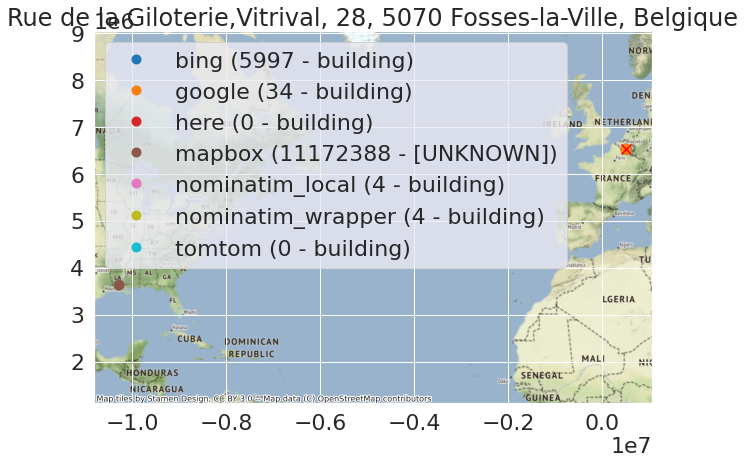

street housenumber postcode   city  \
96    Rue de l'Industrie           2     1301  Wavre   
1954  Rue de l'Industrie           2     1301  Wavre   
2954  Rue de l'Industrie           2     1301  Wavre   
3954  Rue de l'Industrie           2     1301  Wavre   
4954  Rue de l'Industrie           2     1301  Wavre   
5947  Rue de l'Industrie           2     1301  Wavre   

                                          address  \
96    Rue de l'Industrie, 2, 1301 Wavre, Belgique   
1954  Rue de l'Industrie, 2, 1301 Wavre, Belgique   
2954  Rue de l'Industrie, 2, 1301 Wavre, Belgique   
3954  Rue de l'Industrie, 2, 1301 Wavre, Belgique   
4954  Rue de l'Industrie, 2, 1301 Wavre, Belgique   
5947  Rue de l'Industrie, 2, 1301 Wavre, Belgique   

                                               location           geocoder  \
96    (Rue de l'Industrie, Loncin, Ans, Liège, Wallo...  nominatim_wrapper   
1954  (Rue de l'Industrie 2, 1301 Wavre, Belgique, W...               here   
2954  (Rue de l'industrie 2, Wavre, Walloon Region 1...               bing   
3954  (Rue De La Dyle 2, 1301 Wavre, Walloon Brabant...             mapbox   
4954  (Rue de l'Industrie 2, 1301 Wavre, (50.7058, 4...             tomtom   
5947  (Rue de l'Industrie 2, 1301 Wavre, Belgium, (5...             google   

      duration precision                           point  is_in_belgium  \
96    2.961241    street  POINT (612645.560 6563235.891)           True   
1954  0.044280  building  POINT (511584.305 6569415.462)           True   
2954  0.250793  building  POINT (511568.787 6569416.745)           True   
3954  0.169833  building  POINT (511568.831 6569416.693)           True   
4954  0.035416  building  POINT (511568.720 6569417.220)           True   
5947  0.110721  building  POINT (511591.407 6569439.895)           True   

                        median_point  nb_points  dist_to_median  \
96    POINT (511568.831 6569416.745)        5.0   101265.532081   
1954  POINT (511568.831 6569416.745)        5.0       15.526523   
2954  POINT (511568.831 6569416.745)        5.0        0.044528   
3954  POINT (511568.831 6569416.745)        5.0        0.052733   
4954  POINT (511568.831 6569416.745)        5.0        0.487476   
5947  POINT (511568.831 6569416.745)        5.0       32.335250   

      nb_close_to_median  has_median  is_value_normal  less_than_10km  \
96                   5.0        True             True           False   
1954                 5.0        True             True           False   
2954                 5.0        True             True           False   
3954                 5.0        True             True           False   
4954                 5.0        True             True           False   
5947                 5.0        True             True           False   

      is_below_top_whisker  is_reliable  
96                    True        False  
1954                  True        False  
2954                  True        False  
3954                  True        False  
4954                  True        False  
5947                  True        False

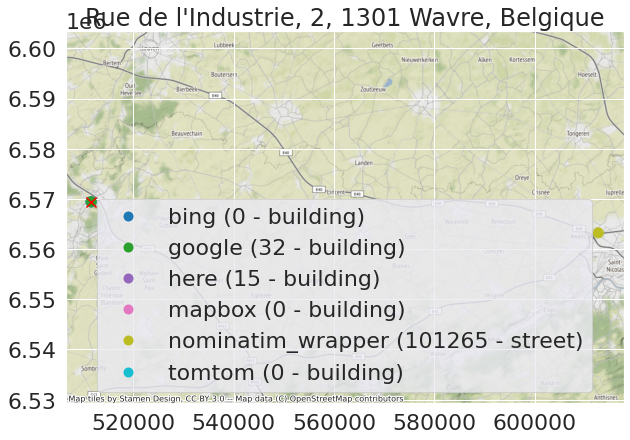

street housenumber postcode       city  \
559   Rue Dieudonné Lefèvre           2     1020  Bruxelles   
1481  Rue Dieudonné Lefèvre           2     1020  Bruxelles   
2420  Rue Dieudonné Lefèvre           2     1020  Bruxelles   
3420  Rue Dieudonné Lefèvre           2     1020  Bruxelles   
4420  Rue Dieudonné Lefèvre           2     1020  Bruxelles   
5416  Rue Dieudonné Lefèvre           2     1020  Bruxelles   
6413  Rue Dieudonné Lefèvre           2     1020  Bruxelles   

                                                address  \
559   Rue Dieudonné Lefèvre, 2, 1020 Bruxelles, Belg...   
1481  Rue Dieudonné Lefèvre, 2, 1020 Bruxelles, Belg...   
2420  Rue Dieudonné Lefèvre, 2, 1020 Bruxelles, Belg...   
3420  Rue Dieudonné Lefèvre, 2, 1020 Bruxelles, Belg...   
4420  Rue Dieudonné Lefèvre, 2, 1020 Bruxelles, Belg...   
5416  Rue Dieudonné Lefèvre, 2, 1020 Bruxelles, Belg...   
6413  Rue Dieudonné Lefèvre, 2, 1020 Bruxelles, Belg...   

                                               location           geocoder  \
559   (Rue Dieudonné Lefèvre - Dieudonné Lefèvrestra...  nominatim_wrapper   
1481  (Rue Dieudonné Lefèvre - Dieudonné Lefèvrestra...    nominatim_local   
2420  (Rue Dieudonné Lefèvre 2, 1020 Bruxelles, Belg...               here   
3420  (Rue François Dieudonné 2, La Louvière, Walloo...               bing   
4420  (Rue Dieudonné Lefèvre - Dieudonné Lefèvrestra...             mapbox   
5416  (Rue Victor Lefèvre 2, 1030 Bruxelles, (50.844...             tomtom   
6413  (Rue Dieudonné Lefèvre 2, 1020 Bruxelles, Belg...             google   

      duration precision                           point  is_in_belgium  \
559   0.075620    street  POINT (484007.261 6598537.471)           True   
1481  0.017718    street  POINT (484007.261 6598537.471)           True   
2420  0.048810  building  POINT (483617.509 6598369.171)           True   
3420  0.251032  building  POINT (461851.754 6524885.830)           True   
4420  0.150808  building  POINT (484394.853 6598367.759)           True   
5416  0.230286  building  POINT (489331.538 6593847.634)           True   
6413  0.115470  building  POINT (484162.262 6598442.657)           True   

                        median_point  nb_points  dist_to_median  \
559   POINT (484162.262 6598367.759)        5.0      229.842308   
1481  POINT (484162.262 6598367.759)        5.0      229.842308   
2420  POINT (484162.262 6598367.759)        5.0      544.754888   
3420  POINT (484162.262 6598367.759)        5.0    76794.222652   
4420  POINT (484162.262 6598367.759)        5.0      232.590944   
5416  POINT (484162.262 6598367.759)        5.0     6866.800707   
6413  POINT (484162.262 6598367.759)        5.0       74.897845   

      nb_close_to_median  has_median  is_value_normal  less_than_10km  \
559                  1.0       False            False           False   
1481                 1.0       False            False           False   
2420                 1.0       False            False           False   
3420                 1.0       False            False           False   
4420                 1.0       False            False           False   
5416                 1.0       False            False           False   
6413                 1.0       False            False           False   

      is_below_top_whisker  is_reliable  
559                  False        False  
1481                 False        False  
2420                 False        False  
3420                 False        False  
4420                 False        False  
5416                 False        False  
6413                 False        False

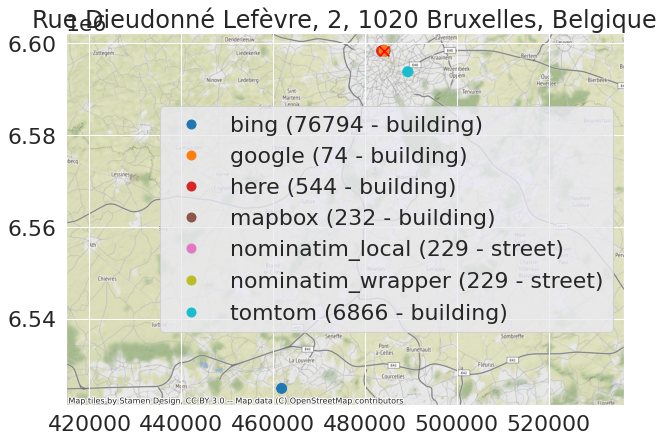

street housenumber postcode       city  \
144   Rue de la Régence       25-27     6000  Charleroi   
1124  Rue de la Régence       25-27     6000  Charleroi   
2002  Rue de la Régence       25-27     6000  Charleroi   
3002  Rue de la Régence       25-27     6000  Charleroi   
4002  Rue de la Régence       25-27     6000  Charleroi   
5002  Rue de la Régence       25-27     6000  Charleroi   
5995  Rue de la Régence       25-27     6000  Charleroi   

                                                address  \
144   Rue de la Régence, 25-27, 6000 Charleroi, Belg...   
1124  Rue de la Régence, 25-27, 6000 Charleroi, Belg...   
2002  Rue de la Régence, 25-27, 6000 Charleroi, Belg...   
3002  Rue de la Régence, 25-27, 6000 Charleroi, Belg...   
4002  Rue de la Régence, 25-27, 6000 Charleroi, Belg...   
5002  Rue de la Régence, 25-27, 6000 Charleroi, Belg...   
5995  Rue de la Régence, 25-27, 6000 Charleroi, Belg...   

                                               location           geocoder  \
144   (Rue de la Régence, Charleroi, Hainaut, Wallon...  nominatim_wrapper   
1124  (Rue de la Régence, Charleroi, Hainaut, Wallon...    nominatim_local   
2002  (Rue de la Régence 25, 6000 Charleroi, Belgiqu...               here   
3002  (Rue de la Régence 25, Charleroi, Walloon Regi...               bing   
4002  (Rue De La Régence, 6000 Charleroi, Hainaut, B...             mapbox   
5002  (Rue de la Régence 25, 6000 Charleroi, (50.412...             tomtom   
5995  (Rue de la Régence 25, 1000 Bruxelles, Belgium...             google   

      duration precision                           point  is_in_belgium  \
144   0.044850    street  POINT (495044.811 6518301.636)           True   
1124  0.022149    street  POINT (495044.811 6518301.636)           True   
2002  0.099031  building  POINT (494920.890 6518078.331)           True   
3002  0.247740  building  POINT (494920.990 6518077.684)           True   
4002  0.260271    street  POINT (494934.475 6518097.769)           True   
5002  0.431625  building  POINT (494920.890 6518078.331)           True   
5995  0.118388  building  POINT (484807.503 6592931.673)           True   

                        median_point  nb_points  dist_to_median  \
144   POINT (494920.890 6518078.331)        4.0      255.385231   
1124  POINT (494920.890 6518078.331)        4.0      255.385231   
2002  POINT (494920.890 6518078.331)        4.0        0.000000   
3002  POINT (494920.890 6518078.331)        4.0        0.654060   
4002  POINT (494920.890 6518078.331)        4.0       23.715190   
5002  POINT (494920.890 6518078.331)        4.0        0.000000   
5995  POINT (494920.890 6518078.331)        4.0    75533.459499   

      nb_close_to_median  has_median  is_value_normal  less_than_10km  \
144                  4.0        True             True           False   
1124                 4.0        True             True           False   
2002                 4.0        True             True           False   
3002                 4.0        True             True           False   
4002                 4.0        True             True           False   
5002                 4.0        True             True           False   
5995                 4.0        True             True           False   

      is_below_top_whisker  is_reliable  
144                   True        False  
1124                  True        False  
2002                  True        False  
3002                  True        False  
4002                  True        False  
5002                  True        False  
5995                  True        False

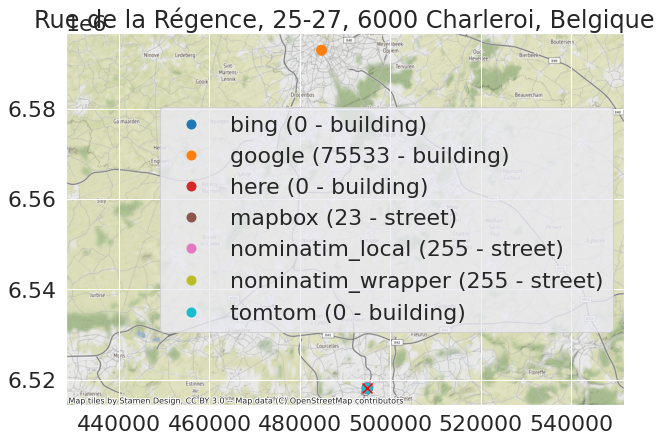

street housenumber postcode   city  \
983   Avenue Jean Pochet(BL)          82     5001  Namur   
2845  Avenue Jean Pochet(BL)          82     5001  Namur   
3845  Avenue Jean Pochet(BL)          82     5001  Namur   
4845  Avenue Jean Pochet(BL)          82     5001  Namur   
5838  Avenue Jean Pochet(BL)          82     5001  Namur   
6838  Avenue Jean Pochet(BL)          82     5001  Namur   

                                               address  \
983   Avenue Jean Pochet(BL), 82, 5001 Namur, Belgique   
2845  Avenue Jean Pochet(BL), 82, 5001 Namur, Belgique   
3845  Avenue Jean Pochet(BL), 82, 5001 Namur, Belgique   
4845  Avenue Jean Pochet(BL), 82, 5001 Namur, Belgique   
5838  Avenue Jean Pochet(BL), 82, 5001 Namur, Belgique   
6838  Avenue Jean Pochet(BL), 82, 5001 Namur, Belgique   

                                               location           geocoder  \
983   (Avenue Jean Pochet, Belgrade, Namur, Wallonie...  nominatim_wrapper   
2845  (Avenue Jean Pochet 82, 5001 Namur, Belgique, ...               here   
3845  (Avenue Jean Pochet 82, Namur, Walloon Region ...               bing   
4845  (Mean, Havelange, Namur, Belgium, (50.361924, ...             mapbox   
5838  (Avenue Jean Pochet 82, 5001 Namur, (50.47233,...             tomtom   
6838  (Av. Jean Pochet 82, 5001 Namur, Belgium, (50....             google   

      duration  precision                           point  is_in_belgium  \
983   0.189570     street  POINT (536356.064 6528502.626)           True   
2845  0.085017   building  POINT (536031.178 6528480.483)           True   
3845  0.266636   building  POINT (536030.955 6528480.711)           True   
4845  0.180644  [UNKNOWN]  POINT (593762.134 6509192.238)           True   
5838  0.205175   building  POINT (536031.178 6528480.483)           True   
6838  0.108129   building  POINT (536034.974 6528480.046)           True   

                        median_point  nb_points  dist_to_median  \
983   POINT (536031.178 6528480.483)        4.0      325.639666   
2845  POINT (536031.178 6528480.483)        4.0        0.000000   
3845  POINT (536031.178 6528480.483)        4.0        0.318228   
4845  POINT (536031.178 6528480.483)        4.0    60867.887002   
5838  POINT (536031.178 6528480.483)        4.0        0.000000   
6838  POINT (536031.178 6528480.483)        4.0        3.821096   

      nb_close_to_median  has_median  is_value_normal  less_than_10km  \
983                  4.0        True             True           False   
2845                 4.0        True             True           False   
3845                 4.0        True             True           False   
4845                 4.0        True             True           False   
5838                 4.0        True             True           False   
6838                 4.0        True             True           False   

      is_below_top_whisker  is_reliable  
983                   True        False  
2845                  True        False  
3845                  True        False  
4845                  True        False  
5838                  True        False  
6838                  True        False

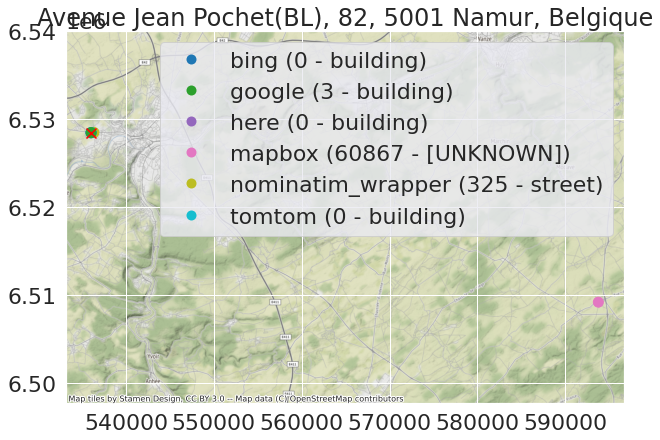

In [292]:
for a in geocoded_data.sort_values("dist_to_median", ascending=False).address.unique()[0:5]:
    #print(a)
    plot_address(geocoded_data, a)
   

In [293]:
# geocoders["bing"].geocode("Rue Le Lorrain, 4, 1080 Molenbeek-Saint-Jean, Belgique")

In [294]:
# geocoded_data.loc[25].location.raw

## Median pertinence

How many close to median ?

In [295]:
nb_close_to_median = geocoded_data.assign(close_to_median = geocoded_data.dist_to_median < 100).groupby("address").close_to_median.sum()

nb_close_to_median

address
't Vlietje, 4, 2800 Mechelen, Belgique                7
Aalstersesteenweg, 362, 9400 Ninove, Belgique         4
Aaltersesteenweg, 122, 9800 Deinze, Belgique          7
Aarschotsesteenweg, 22, 3012 Leuven, Belgique         7
Aarschotsesteenweg, 54A, 3110 Rotselaar, Belgique     5
                                                     ..
de Burburelaan, 46, 1970 Wezembeek-Oppem, Belgique    5
de Limburg Stirumlaan, 100, 1780 Wemmel, Belgique     5
de Smet de Naeyerlaan, 526, 1020 Brussel, Belgique    5
rue des Maraîchers, 9, 1070 Anderlecht, Belgique      7
rue du Chenia, 15, 7170 Manage, Belgique              1
Name: close_to_median, Length: 997, dtype: int64

In [296]:
median_points = median_points.merge(nb_close_to_median.rename("nb_close_to_median").reset_index())

In [297]:
median_points.nb_close_to_median.value_counts()

7     537
5     148
6     100
4      87
3      55
2      18
0      18
1       4
14      3
Name: nb_close_to_median, dtype: int64

In [298]:
median_points[median_points.nb_close_to_median>=2]

address  \
0               't Vlietje, 4, 2800 Mechelen, Belgique   
1        Aalstersesteenweg, 362, 9400 Ninove, Belgique   
2         Aaltersesteenweg, 122, 9800 Deinze, Belgique   
3        Aarschotsesteenweg, 22, 3012 Leuven, Belgique   
4    Aarschotsesteenweg, 54A, 3110 Rotselaar, Belgique   
..                                                 ...   
964          Zur Domäne, 39, 4750 Bütgenbach, Belgique   
965  de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
966  de Limburg Stirumlaan, 100, 1780 Wemmel, Belgique   
967  de Smet de Naeyerlaan, 526, 1020 Brussel, Belg...   
968   rue des Maraîchers, 9, 1070 Anderlecht, Belgique   

                       median_point  nb_points  nb_close_to_median  
0    POINT (499196.315 6626069.331)          6                   7  
1    POINT (449065.119 6596429.049)          5                   4  
2    POINT (389868.103 6620321.889)          6                   7  
3    POINT (524091.923 6601928.128)          6                   7  
4    POINT (527891.497 6611051.200)          5                   5  
..                              ...        ...                 ...  
964  POINT (692725.000 6517833.816)          6                   7  
965  POINT (498587.754 6595071.625)          5                   5  
966  POINT (480158.345 6604332.636)          5                   5  
967  POINT (483041.653 6600914.669)          5                   5  
968  POINT (478803.603 6592983.817)          6                   7  

[948 rows x 4 columns]

In [299]:
nb_close_to_median.value_counts()

7     537
5     148
6     100
4      87
3      55
0      45
2      18
1       4
14      3
Name: close_to_median, dtype: int64

In [300]:
geocoded_data = geocoded_data.merge(median_points, how="left")


In [301]:
geocoded_data.loc[geocoded_data.nb_close_to_median <2, "dist_to_median"] = pd.NA

In [302]:
geocoded_data[geocoded_data.dist_to_median.notnull()].address.nunique()

948

street housenumber postcode   city  \
766   Boulevard du Rectorat         27B     4000  Liège   
1663  Boulevard du Rectorat         27B     4000  Liège   
2627  Boulevard du Rectorat         27B     4000  Liège   
3627  Boulevard du Rectorat         27B     4000  Liège   
4627  Boulevard du Rectorat         27B     4000  Liège   
5621  Boulevard du Rectorat         27B     4000  Liège   
6620  Boulevard du Rectorat         27B     4000  Liège   

                                               address  \
766   Boulevard du Rectorat, 27B, 4000 Liège, Belgique   
1663  Boulevard du Rectorat, 27B, 4000 Liège, Belgique   
2627  Boulevard du Rectorat, 27B, 4000 Liège, Belgique   
3627  Boulevard du Rectorat, 27B, 4000 Liège, Belgique   
4627  Boulevard du Rectorat, 27B, 4000 Liège, Belgique   
5621  Boulevard du Rectorat, 27B, 4000 Liège, Belgique   
6620  Boulevard du Rectorat, 27B, 4000 Liège, Belgique   

                                               location           geocoder  \
766   (Boulevard du Rectorat, Liège, Wallonie, 4000,...  nominatim_wrapper   
1663  (Boulevard du Rectorat, Liège, Wallonie, 4000,...    nominatim_local   
2627  (Boulevard du Rectorat 27B, 4000 Liège, Belgiq...               here   
3627  (Boulevard du Rectorat, Liège, Walloon Region ...               bing   
4627  (Boulevard Du Rectorat 27b, 4000 Liège, Liege,...             mapbox   
5621  (Rue du Champion 27, 4000 Liège, (50.643, 5.57...             tomtom   
6620  (Bd du Rectorat 27b, 4000 Liège, Belgium, (50....             google   

      duration precision                           point  is_in_belgium  \
766   0.127612    street  POINT (622356.015 6546838.054)           True   
1663  0.041371    street  POINT (622356.015 6546838.054)           True   
2627  0.054630  building  POINT (618980.084 6547637.704)           True   
3627  0.238864    street  POINT (619371.373 6548000.703)           True   
4627  0.307754  building  POINT (620719.262 6547046.150)           True   
5621  0.279479  building  POINT (620800.970 6558385.861)           True   
6620  0.118532  building  POINT (620664.192 6546973.891)           True   

                        median_point  nb_points dist_to_median  \
766   POINT (620691.727 6547341.927)        4.0           <NA>   
1663  POINT (620691.727 6547341.927)        4.0           <NA>   
2627  POINT (620691.727 6547341.927)        4.0           <NA>   
3627  POINT (620691.727 6547341.927)        4.0           <NA>   
4627  POINT (620691.727 6547341.927)        4.0           <NA>   
5621  POINT (620691.727 6547341.927)        4.0           <NA>   
6620  POINT (620691.727 6547341.927)        4.0           <NA>   

      nb_close_to_median  has_median  is_value_normal  less_than_10km  \
766                  0.0       False            False           False   
1663                 0.0       False            False           False   
2627                 0.0       False            False           False   
3627                 0.0       False            False           False   
4627                 0.0       False            False           False   
5621                 0.0       False            False           False   
6620                 0.0       False            False           False   

      is_below_top_whisker  is_reliable  
766                  False        False  
1663                 False        False  
2627                 False        False  
3627                 False        False  
4627                 False        False  
5621                 False        False  
6620                 False        False

No median point


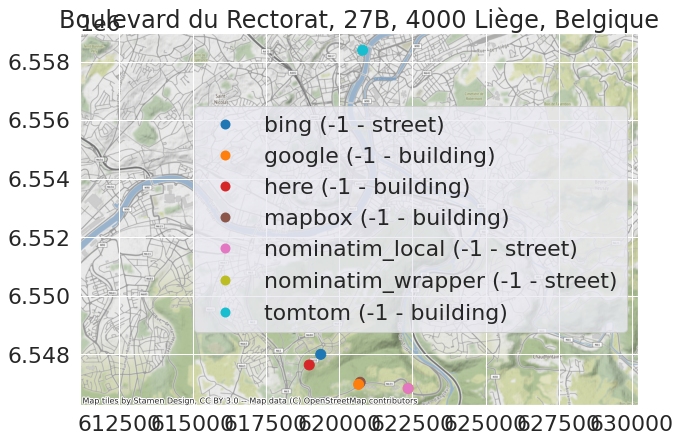

In [303]:
for a in nb_close_to_median[nb_close_to_median==0].iloc[0:10].index:
    #print(a)
    if geocoded_data[geocoded_data.address == a].median_point.notnull().any():
        plot_address(geocoded_data[geocoded_data.median_point.notnull()], a)
  

# Statistics

In [304]:
# geocoded_data


## Add selectors

In [305]:
geocoded_data["has_median"] = geocoded_data.dist_to_median.notnull()
geocoded_data["has_median"].value_counts()

True     6531
False     319
Name: has_median, dtype: int64

In [306]:
geocoded_data[geocoded_data["has_median"]].address.nunique()

948

In [307]:
# geocoded_data["is_median_reliable"] =   geocoded_data["nb_close_to_median"]>=2
# geocoded_data.is_median_reliable.value_counts()

In [308]:
geocoded_data["is_value_normal"]    = geocoded_data.dist_to_median < geocoded_data.dist_to_median.quantile(0.995)
geocoded_data.is_value_normal.value_counts() # / geocoded_data.shape[0]

True     6498
False     352
Name: is_value_normal, dtype: int64

In [309]:
geocoded_data["less_than_10km"]    = geocoded_data.dist_to_median < 10000
geocoded_data.less_than_10km.value_counts() # / geocoded_data.shape[0]

True     6517
False     333
Name: less_than_10km, dtype: int64

<AxesSubplot:>

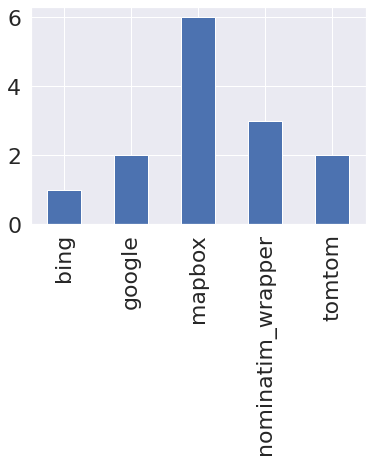

In [310]:
geocoded_data[(geocoded_data.geocoder != "trillium") & (geocoded_data.dist_to_median > 10000)].geocoder.value_counts().sort_index().plot.bar()

In [311]:
geocoded_data.dist_to_median.quantile(0.99)

3102.7908286201473

In [312]:
pd.crosstab(geocoded_data.is_value_normal, geocoded_data.is_in_belgium)

is_in_belgium    False  True
is_value_normal             
False                3   349
True                 0  6498

In [313]:
#Q3 + (Q3-Q1 = IQR) * 1.5 
top_whisker = geocoded_data.dist_to_median.quantile(0.75) + (geocoded_data.dist_to_median.quantile(0.75) - geocoded_data.dist_to_median.quantile(0.25))*1.5
geocoded_data["is_below_top_whisker"]    = geocoded_data.dist_to_median < top_whisker
geocoded_data.is_below_top_whisker.value_counts()

True     5422
False    1428
Name: is_below_top_whisker, dtype: int64

In [314]:
geocoded_data.dist_to_median.quantile(0.75) 

19.869146677682366

In [315]:
# geocoded_data[geocoded_data.is_below_top_whisker].dist_to_median.hist(bins=100)

In [316]:
top_whisker

49.01253077739906

In [317]:
# geocoded_data[~geocoded_data.is_below_top_whisker]

In [318]:
geocoded_data.dist_to_median.quantile(0.99)

3102.7908286201473

In [319]:
# match_per_addr = geocoded_data.groupby("address").geocoder.count()
# geocoded_data["has_enough_matches"] = geocoded_data.address.isin(match_per_addr[match_per_addr>=3].index)
# geocoded_data["has_enough_matches"].value_counts()

In [320]:
# pd.crosstab(geocoded_data["is_median_reliable"] , geocoded_data["has_enough_matches"])

In [321]:
geocoded_data["is_reliable"] = geocoded_data["is_value_normal"] & \
                               geocoded_data["is_in_belgium"]

#geocoded_data["is_median_reliable"] & \
                               #geocoded_data["has_enough_matches"] &  \

<AxesSubplot:>

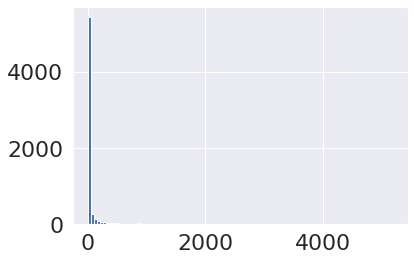

In [322]:
geocoded_data[geocoded_data.is_reliable].dist_to_median.hist(bins=100)

In [323]:
# pd.crosstab(geocoded_data["is_in_belgium"] , geocoded_data["is_value_normal"])

In [324]:
# match_per_addr.value_counts().plot.bar()

In [325]:
geocoded_data[~geocoded_data.is_value_normal].geocoder.value_counts()

mapbox               62
nominatim_wrapper    57
google               54
bing                 53
tomtom               50
here                 49
nominatim_local      27
Name: geocoder, dtype: int64

In [326]:
geocoded_data

street housenumber postcode             city  \
0            de Burburelaan          46     1970  Wezembeek-Oppem   
1           Nachtegalenlaan          35     1950         Kraainem   
2             Rue Tilia(ST)          12     6511         Beaumont   
3            Rue du Hock(N)          36     4121           Neupré   
4           Wuustwezelseweg          95     2990       Wuustwezel   
...                     ...         ...      ...              ...   
6845  Vlasbloemstraat(Woes)           6     8640         Vleteren   
6846              Abtsdreef         259     2940         Stabroek   
6847        Rue des Chalets           5     4030            Liège   
6848             Lichterweg           3     2030        Antwerpen   
6849       Grote Markt(Kor)          41     8500         Kortrijk   

                                                address  \
0     de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1          Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2            Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3             Rue du Hock(N), 36, 4121 Neupré, Belgique   
4        Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
...                                                 ...   
6845  Vlasbloemstraat(Woes), 6, 8640 Vleteren, Belgique   
6846            Abtsdreef, 259, 2940 Stabroek, Belgique   
6847           Rue des Chalets, 5, 4030 Liège, Belgique   
6848            Lichterweg, 3, 2030 Antwerpen, Belgique   
6849      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   

                                               location           geocoder  \
0     (Oscar de Burburelaan, Wezembeek, Wezembeek-Op...  nominatim_wrapper   
1     (35, Nachtegalenlaan, Kraainem, Halle-Vilvoord...  nominatim_wrapper   
2     (Rue Tilia, Strée, Beaumont, Thuin, Hainaut, W...  nominatim_wrapper   
3     (36, Rue du Hock, Neuville-en-Condroz, Neupré,...  nominatim_wrapper   
4     (95, Wuustwezelseweg, Loenhout, Wuustwezel, An...  nominatim_wrapper   
...                                                 ...                ...   
6845  (Vlasbloemstraat, 8640 Vleteren, Belgium, (50....             google   
6846  (Abtsdreef 259, 2940 Stabroek, Belgium, (51.34...             google   
6847  (Rue des Chalets 5, 4030 Liège, Belgium, (50.6...             google   
6848  (Lichterweg 3, 2030 Antwerpen, Belgium, (51.24...             google   
6849        (Kortrijk, Belgium, (50.826806, 3.2543899))             google   

      duration precision                           point  is_in_belgium  \
0     0.141377    street  POINT (498759.064 6595272.461)           True   
1     0.092073  building  POINT (497811.825 6595976.732)           True   
2     0.053527    street  POINT (478780.031 6493264.898)           True   
3     0.089439  building  POINT (607319.913 6542692.124)           True   
4     0.142177  building  POINT (515079.967 6692438.032)           True   
...        ...       ...                             ...            ...   
6845  0.094116    street  POINT (311383.648 6605314.483)           True   
6846  0.112655  building  POINT (483904.123 6682300.566)           True   
6847  0.095659  building  POINT (622374.037 6555779.276)           True   
6848  0.092238  building  POINT (488547.359 6665477.309)           True   
6849  0.086812      city  POINT (362277.027 6590714.701)           True   

                        median_point  nb_points dist_to_median  \
0     POINT (498587.754 6595071.625)        5.0     263.973868   
1     POINT (497812.970 6595975.832)        5.0       1.455976   
2     POINT (479073.247 6493719.741)        4.0     541.163092   
3     POINT (607319.000 6542691.616)        4.0       1.044688   
4     POINT (515081.618 6692445.348)        5.0       7.499792   
...                              ...        ...            ...   
6845  POINT (311045.582 6605752.872)        3.0     553.601038   
6846  POINT (483910.279 6682261.698)        5.0      39.352295   
6847  POINT (622375.696 6555779.311)        5.0    

In [327]:
geocoded_data[["has_median", "is_value_normal", #"is_median_reliable", 
               #"has_enough_matches",
               "is_in_belgium", #"has_enough_matches", 
               "is_below_top_whisker", "is_reliable"]].sum()/geocoded_data.shape[0]

has_median              0.953431
is_value_normal         0.948613
is_in_belgium           0.999562
is_below_top_whisker    0.791533
is_reliable             0.948613
dtype: float64

In [328]:
geocoded_data[~geocoded_data.is_reliable & (geocoded_data.geocoder=="nominatim_wrapper")]

street housenumber postcode  \
26   Rue de la Porte aux Champs(MAR)           8     4210   
39                Rue Taille Gabelle           2     6530   
62                 Rue des Ecoles(M)          34     7870   
72            Boulevard Mairaux(L.L)          21     7100   
96                Rue de l'Industrie           2     1301   
101                    Karveelstraat          40     8380   
172              Rue des Battes(LAN)          24     4600   
196            Place Sainte Ode(AMA)           3     4540   
197             Arthur Renquetstraat          18     3500   
201        Av. du Cimetière de Brux.         134     1140   
212       Marloie, Rue Saint Isidore         101     6900   
223               Bloempotstraat(MD)         19B     9170   
232                    rue du Chenia          15     7170   
253              Rue des Rivaux(L.L)           2     7100   
254             Tienne Beaudoin(AUV)           1     5060   
257    Rue du Pont-à-la Cambe(J.-S.)           9     1370   
272          Allée J.F. Kennedy(Cha)           8     5650   
274                    Industriepark    Zone B 4     2220   
305         Chaussée de Tournai(Irc)         184     7801   
312   Rue des Glaces Nationales(AUV)         169     5060   
358              Puursesteenweg(BOR)         391     2880   
363          Avenue Léopold III(PER)          17     7134   
374                         Rettigny          32     6673   
392              Rue Albert 1er(GER)           8     6280   
394                Rue des Phlox(NN)       51-53     5100   
401     Rue Antoine de Saint-Exupéry           2     6041   
432               Ketelaarsgras(STE)          22     9190   
434               Rue du Relais(CER)           1     4632   
520          Avenue Léonard de Vinci          17     1300   
523                Sint Lenaartseweg          48     2320   
555   Rue de la Terre à Briques(MAR)         29B     7522   
559            Rue Dieudonné Lefèvre           2     1020   
562                 Rue Conreur(L.L)          47     7100   
566         Rue de la Gare,Ste-Marie          31     6740   
572                      Knokke(Ren)           1     8647   
585        Rue des Droits de l'Homme         5-3     7160   
611          Boulevard André Delvaux          15     7000   
622                Rue de Baume(L.L)         377     7100   
625               Rue des Heids(AYE)          11     4630   
631                    Ville-du-Bois         173     6690   
649            Chaussée de Lille(OR)       479/2     7501   
674                      Bareel(DKL)          13     9170   
680                     Rue d'Abhooz          31     4040   
713                          Zeedijk          96     8400   
714                       Heide(LUB)          53     3210   
715        Chaussée de Courtrai(FRY)           2     7503   
728          Rue du Mont d'Orcq(FRY)          14     7503   
743         Avenue Reine Astrid(W-B)          16     1440   
765                        Zandvoort          10     2030   
766            Boulevard du Rectorat         27B     4000   
835    Industrieterrein Kanaal-Noord        1402     3960   
897                    Route d'Arlon         220     6780   
918     Rue Isidore-Derèse,Mornimont         155     5190   
936       Chaussée de Bruxelles(TOU)         190     7500   
937                 Rue de Lassus(H)          46     7712   
945                Franseweg (Heide)          33     2920   
992                       Lichterweg           3     2030   

                        city  \
26                  Burdinne   
39                     Thuin   
62            Lens (Hainaut)   
72               La Louvière   
96                     Wavre   
101                   Brugge   
172                     Visé   
196                     Amay   
197                  Hasselt   
201                    Evere   
212        Marche-en-Famenne   
223         Sint-Gillis-Waas   
232                   Manage   
253              La Louvière   
254        

In [329]:
geocoded_data.geocoder.value_counts()

here                 1000
bing                 1000
mapbox               1000
google               1000
nominatim_wrapper     994
tomtom                993
nominatim_local       863
Name: geocoder, dtype: int64

## Matching rate

In [330]:
# geocoded_data.groupby("geocoder").address.count()/ data.shape[0]
data

street housenumber postcode             city  \
0           de Burburelaan          46     1970  Wezembeek-Oppem   
1          Nachtegalenlaan          35     1950         Kraainem   
2            Rue Tilia(ST)          12     6511         Beaumont   
3           Rue du Hock(N)          36     4121           Neupré   
4          Wuustwezelseweg          95     2990       Wuustwezel   
..                     ...         ...      ...              ...   
995  Vlasbloemstraat(Woes)           6     8640         Vleteren   
996              Abtsdreef         259     2940         Stabroek   
997        Rue des Chalets           5     4030            Liège   
998             Lichterweg           3     2030        Antwerpen   
999       Grote Markt(Kor)          41     8500         Kortrijk   

                                               address  
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...  
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique  
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique  
3            Rue du Hock(N), 36, 4121 Neupré, Belgique  
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique  
..                                                 ...  
995  Vlasbloemstraat(Woes), 6, 8640 Vleteren, Belgique  
996            Abtsdreef, 259, 2940 Stabroek, Belgique  
997           Rue des Chalets, 5, 4030 Liège, Belgique  
998            Lichterweg, 3, 2030 Antwerpen, Belgique  
999      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique  

[1000 rows x 5 columns]

In [331]:
mr = (geocoded_data.groupby("geocoder").address.count()/ data.shape[0])

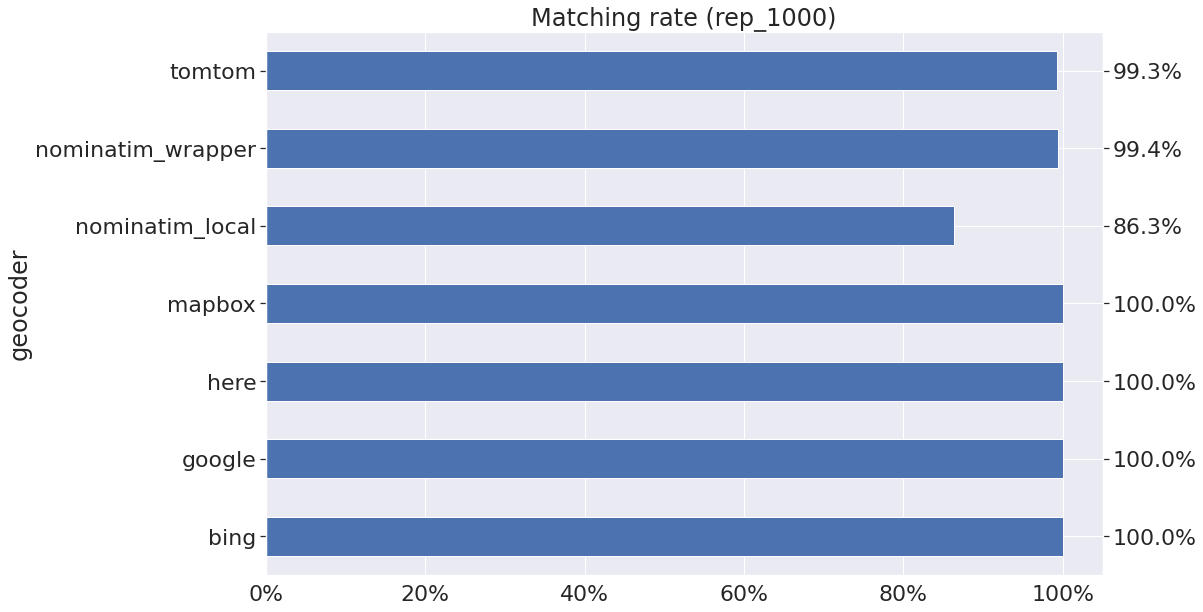

In [332]:
def show_values_on_hbars(ax, values):
    
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(ax.get_yticks())
    ax2.set_yticklabels(values.apply("{:.1%}".format))#mr_prec_plot.get_yticklabels())
    # ax2.xaxis.set_major_formatter('')
    ax2.grid(axis='y')    

plt.figure(figsize=(15,10))
sbn.set(font_scale=2)

mr_plot=mr.rename("matching rate").plot.barh(title=f"Matching rate ({ds})")

show_values_on_hbars(mr_plot, mr)

mr_plot.xaxis.set_major_formatter('{x:.0%}')


pdf.savefig( bbox_inches='tight')

sbn.set(font_scale=1)



In [333]:
# # Only reliable records
# mr = (geocoded_data[geocoded_data.is_reliable].groupby("geocoder").address.count()/ geocoded_data[geocoded_data.is_reliable].address.nunique())

# plt.figure(figsize=(15,10))
# sbn.set(font_scale=2)

# mr_plot=mr.rename("matching rate").plot.barh(title="Matching rate (only reliable)")
# show_values_on_hbars(mr_plot)
# mr_plot.xaxis.set_major_formatter('{x:.0%}')
# # mr.reset_index()
# plt.savefig(f"{fig_path}/matching_rate_reliable_{dataset}.png", bbox_inches='tight')

# pdf.add_page()
# pdf.image(f"{fig_path}/matching_rate_reliable_{dataset}.png",0,0, 210)

# sbn.set(font_scale=1)

<AxesSubplot:title={'center':'Number of success per address'}>

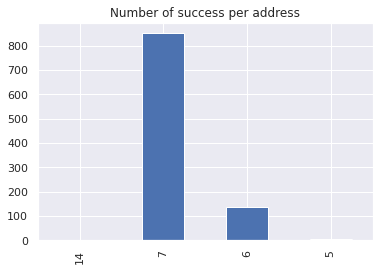

In [334]:
geocoded_data.groupby("address").geocoder.count().value_counts().sort_index(ascending=False).plot.bar(title="Number of success per address")

## Precision

In [335]:
# geocoded_data.groupby(["geocoder", "precision"]).address.count().unstack().plot.bar(stacked=True)
# plt.savefig(f"{fig_path}/matching_rate_precision_{dataset}.png")
mr

geocoder
bing                 1.000
google               1.000
here                 1.000
mapbox               1.000
nominatim_local      0.863
nominatim_wrapper    0.994
tomtom               0.993
Name: address, dtype: float64

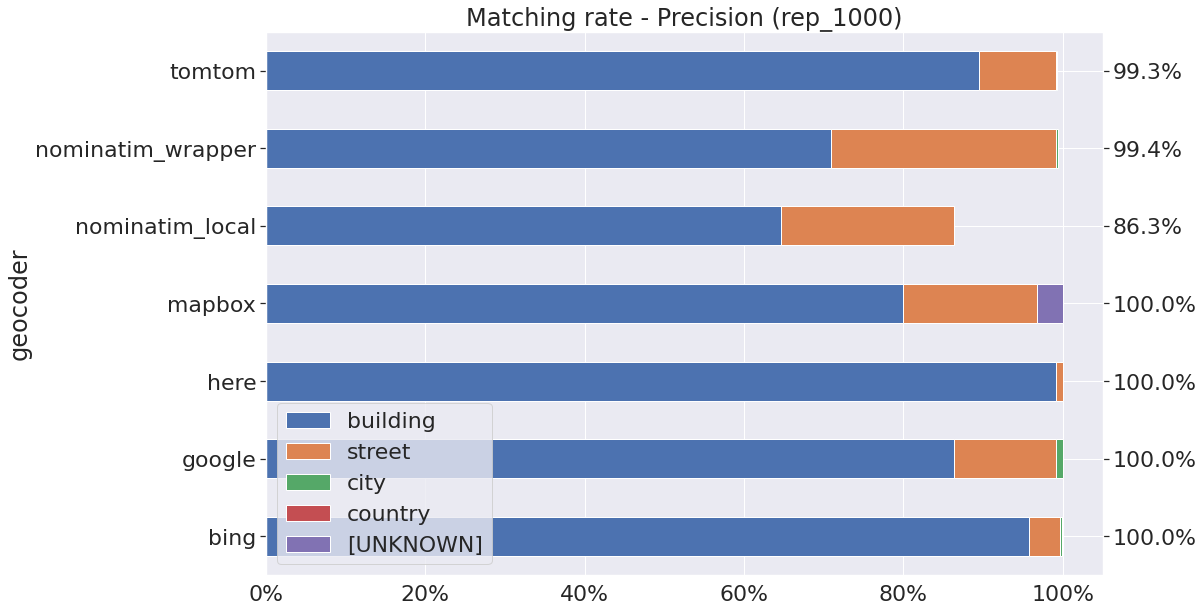

In [336]:
sbn.set(font_scale=2)
mr_prec = geocoded_data.groupby(["geocoder", "precision"]).address.count().unstack()
mr_prec = mr_prec/data.shape[0]
mr_prec = mr_prec.reindex(["building", "street", "city", "country", "[UNKNOWN]"], axis=1)
mr_prec_plot= mr_prec.plot.barh(stacked=True, figsize=(15,10), title=f"Matching rate - Precision ({ds})")
mr_prec_plot.xaxis.set_major_formatter('{x:.0%}')

plt.legend(loc='lower left')

show_values_on_hbars(mr_prec_plot, mr)

pdf.savefig(bbox_inches='tight')

sbn.set(font_scale=1)


In [337]:
# no builing MR (for Nominatim):
# best : 31.6+0.4 = 32 %
# kbo : 24+1 = 25 %
# resto : 13.1 + 4.5 = 17.5 

mr_prec


precision          building  street   city  country  [UNKNOWN]
geocoder                                                      
bing                  0.958   0.038  0.003      NaN      0.001
google                0.863   0.129  0.008      NaN        NaN
here                  0.992   0.008    NaN      NaN        NaN
mapbox                0.799   0.169    NaN      NaN      0.032
nominatim_local       0.646   0.217    NaN      NaN        NaN
nominatim_wrapper     0.709   0.283  0.002      NaN        NaN
tomtom                0.895   0.097  0.001      NaN        NaN

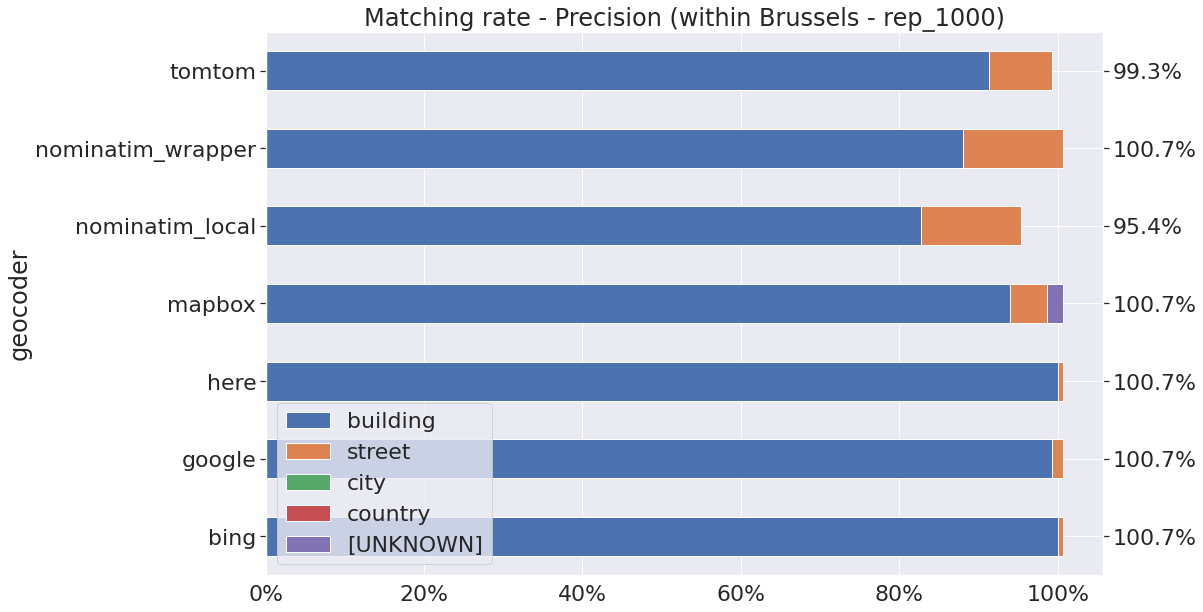

In [338]:
bru_boundaries = gpd.read_file("data/boundaries.geojson")
bru_boundaries = bru_boundaries[bru_boundaries.name == "BRU"].geometry.iloc[0].simplify(1000).buffer(1000)

addr_in_bru = geocoded_data[geocoded_data.point.within(bru_boundaries)].address
geocoded_data_bru = geocoded_data[geocoded_data.address.isin(addr_in_bru)] 


sbn.set(font_scale=2)
mr_prec = geocoded_data_bru.groupby(["geocoder", "precision"]).address.count().unstack()
mr_prec = mr_prec/geocoded_data_bru.address.nunique()
mr_prec = mr_prec.reindex(["building", "street", "city", "country", "[UNKNOWN]"], axis=1)

mr_prec_plot= mr_prec.plot.barh(stacked=True, figsize=(15,10), title=f"Matching rate - Precision (within Brussels - {ds})")
mr_prec_plot.xaxis.set_major_formatter('{x:.0%}')

plt.legend(loc='lower left')



mr_bru = (geocoded_data_bru.groupby("geocoder").address.count()/ geocoded_data_bru.address.nunique())

show_values_on_hbars(mr_prec_plot, mr_bru)


pdf.savefig(bbox_inches='tight')

sbn.set(font_scale=1)

In [339]:
# geocoded_data[geocoded_data.point.within(bru_boundaries)]

In [340]:
mr_prec

precision          building    street  city  country  [UNKNOWN]
geocoder                                                       
bing               1.000000  0.006623   NaN      NaN        NaN
google             0.993377  0.013245   NaN      NaN        NaN
here               1.000000  0.006623   NaN      NaN        NaN
mapbox             0.940397  0.046358   NaN      NaN   0.019868
nominatim_local    0.827815  0.125828   NaN      NaN        NaN
nominatim_wrapper  0.880795  0.125828   NaN      NaN        NaN
tomtom             0.913907  0.079470   NaN      NaN        NaN

In [341]:
geocoded_data[(geocoded_data.geocoder=="pelias") & (geocoded_data.precision == "city")]

Empty GeoDataFrame
Columns: [street, housenumber, postcode, city, address, location, geocoder, duration, precision, point, is_in_belgium, median_point, nb_points, dist_to_median, nb_close_to_median, has_median, is_value_normal, less_than_10km, is_below_top_whisker, is_reliable]
Index: []

In [342]:
# geocoders["pelias"].geocode("Rue Nicolas Arnold, 4800 Verviers").raw

In [343]:
# geocoders["nominatim"].geocode("Rue Nicolas Arnold, 4800 Verviers")

## Distance to median

### Average

geocoder
bing                    73.099884
google                 224.256050
here                    21.373542
mapbox               12032.058518
nominatim_local        184.901423
nominatim_wrapper      384.968542
tomtom                  82.380759
Name: dist_to_median, dtype: float64

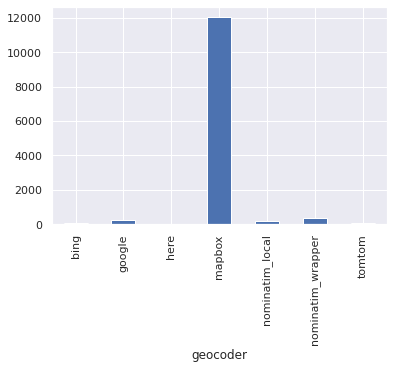

In [344]:
d2m = geocoded_data[geocoded_data.geocoder!= "trillium"].groupby("geocoder").dist_to_median.mean()
d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_{dataset}.png")
d2m

In [345]:
# geocoded_data.pivot(index="address", columns="geocoder", values="dist_to_median").plot.box()

In [346]:
# # skipping top 1%
# d2m = geocoded_data[geocoded_data.is_value_normal].groupby("geocoder").dist_to_median.mean()
# d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_skip1pc_{dataset}.png")
# d2m

In [347]:
# geocoded_data[geocoded_data.is_value_normal].pivot(index="address", columns="geocoder", values="dist_to_median").plot.box()

geocoder
bing                  73.099884
google               224.256050
here                  21.373542
mapbox               284.314524
nominatim_local      184.901423
nominatim_wrapper    384.968542
tomtom                82.380759
Name: dist_to_median, dtype: float64

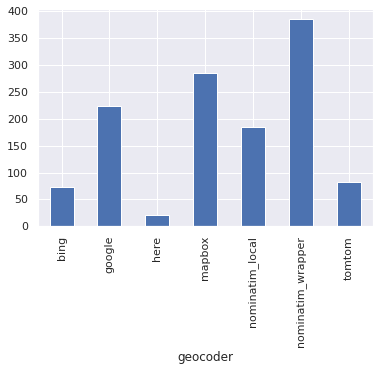

In [348]:
# skipping non reliable median

d2m = geocoded_data[geocoded_data.is_reliable].groupby("geocoder").dist_to_median.mean()
d2m = geocoded_data[geocoded_data.is_in_belgium].groupby("geocoder").dist_to_median.mean()
d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_reliable_{dataset}.png")
d2m

geocoder
bing                  33.379190
google               104.257394
here                  21.373542
mapbox               107.149016
nominatim_local      176.845819
nominatim_wrapper    209.795898
tomtom                48.603451
Name: dist_to_median, dtype: float64

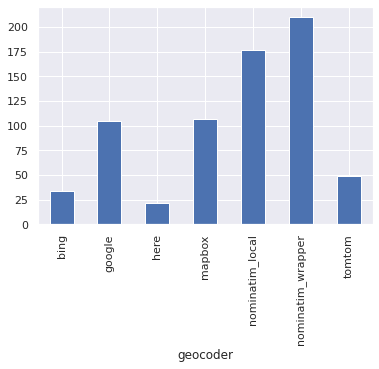

In [349]:
d2m = geocoded_data[geocoded_data.is_reliable].groupby("geocoder").dist_to_median.mean()
d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_reliable_{dataset}.png")
d2m

In [350]:
geocoded_data[geocoded_data.dist_to_median>100000]

street housenumber postcode             city  \
96              Rue de l'Industrie           2     1301            Wavre   
4843  Rue de la Giloterie,Vitrival          28     5070  Fosses-la-Ville   

                                                address  \
96          Rue de l'Industrie, 2, 1301 Wavre, Belgique   
4843  Rue de la Giloterie,Vitrival, 28, 5070 Fosses-...   

                                               location           geocoder  \
96    (Rue de l'Industrie, Loncin, Ans, Liège, Wallo...  nominatim_wrapper   
4843  (Louisiana, United States, (30.9374993015932, ...             mapbox   

      duration  precision                              point  is_in_belgium  \
96    2.961241     street     POINT (612645.560 6563235.891)           True   
4843  0.174292  [UNKNOWN]  POINT (-10275456.702 3624634.895)          False   

                        median_point  nb_points   dist_to_median  \
96    POINT (511568.831 6569416.745)        5.0    101265.532081   
4843  POINT (516581.437 6514995.681)        4.0  11172388.852153   

      nb_close_to_median  has_median  is_value_normal  less_than_10km  \
96                   5.0        True            False           False   
4843                 5.0        True            False           False   

      is_below_top_whisker  is_reliable  
96                   False        False  
4843                 False        False

In [351]:
geocoded_data[geocoded_data.address.str.contains("Monté")]

Empty GeoDataFrame
Columns: [street, housenumber, postcode, city, address, location, geocoder, duration, precision, point, is_in_belgium, median_point, nb_points, dist_to_median, nb_close_to_median, has_median, is_value_normal, less_than_10km, is_below_top_whisker, is_reliable]
Index: []

In [352]:
geocoders["bing"].geocode("Rue du Luxembourg, 68, 1000 BRUXELLES CENTRE")

Location(Rue du Luxembourg 68, Brussels, Brussels Region 1000, Belgium, (50.8394655, 4.3720465, 0.0))

In [353]:
# geocoded_data.groupby(["geocoder", "precision"]).dist_to_median.mean().unstack().plot.bar()

In [354]:
#  geocoded_data[geocoded_data.is_reliable].groupby(["geocoder", "precision"]).dist_to_median.mean().unstack().plot.bar(figsize=(15,10))

In [355]:
# dist2med= geocoded_data[geocoded_data.is_reliable].groupby(["geocoder", "precision"]).dist_to_median.mean().unstack().fillna(0)
# dist2med

In [356]:
# mr_prec#.shape

In [357]:
# a = geocoded_data[geocoded_data.precision=="[UNKNOWN]"].pivot(index="address", columns="geocoder", values="dist_to_median")
# a

In [363]:
# Boxplot: 
# box: Q1-median(Q2)-Q3
# top whisker:    highest point that falls within Q3 + (Q3-Q1 = IQR) * 1.5 
# bottom whisker: lowest  point that falls within Q1 - (IQR) * 1.5 

def show_precision_stats(geocoded_data, title):
    
    mr_prec = geocoded_data.groupby(["geocoder", "precision"]).address.count().unstack()
    dist2med= geocoded_data.groupby(["geocoder", "precision"]).dist_to_median.mean().unstack()
    
    mr_prec["all"] = geocoded_data.groupby(["geocoder"]).address.count()
    dist2med["all"] = geocoded_data.groupby(["geocoder"]).dist_to_median.mean()
    
    fig, ax =plt.subplots(mr_prec.shape[1], 3, figsize=(15, 20)) #
    fig.suptitle(title)
#     plt.gca().set_title(title)
    filters = [(r, (geocoded_data.precision==r)) for r in geocoded_data.precision.unique()]
    filters.append(("all", geocoded_data.precision.notnull()))
    
    colors = [f"C{i}" for i in range(geocoded_data.geocoder.nunique())]
    for i, (r, fltr) in enumerate(filters): 
        #print(r, i)
        dist2med[r].plot.bar(ax=ax[i][0], color=colors)
        #plt.show()
        d = geocoded_data[fltr].pivot(index="address", columns="geocoder", values="dist_to_median")
        d  =d.reindex(mr_prec.index, axis=1)
        display(d)
        #return d
        d[~d.isnull().all(axis=1)].plot.box(ax=ax[i][1], rot=90)

        mr_prec[r].plot.bar(ax=ax[i][2], color=colors)

        plt.setp(ax[i, 0], ylabel=r)
        #plt.setp(axs[:, 0], ylabel='y axis label')

    plt.setp(ax[0, 0], title="Average distance")
    plt.setp(ax[0, 1], title="Distance distribution")
    plt.setp(ax[0, 2], title="Number of matches")


In [359]:
# geocoded_data.groupby(["geocoder"]).address.count()#.unstack()
# geocoded_data.groupby(["geocoder"]).dist_to_median.mean()#.unstack()
geocoded_data

street housenumber postcode             city  \
0            de Burburelaan          46     1970  Wezembeek-Oppem   
1           Nachtegalenlaan          35     1950         Kraainem   
2             Rue Tilia(ST)          12     6511         Beaumont   
3            Rue du Hock(N)          36     4121           Neupré   
4           Wuustwezelseweg          95     2990       Wuustwezel   
...                     ...         ...      ...              ...   
6845  Vlasbloemstraat(Woes)           6     8640         Vleteren   
6846              Abtsdreef         259     2940         Stabroek   
6847        Rue des Chalets           5     4030            Liège   
6848             Lichterweg           3     2030        Antwerpen   
6849       Grote Markt(Kor)          41     8500         Kortrijk   

                                                address  \
0     de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1          Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2            Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3             Rue du Hock(N), 36, 4121 Neupré, Belgique   
4        Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
...                                                 ...   
6845  Vlasbloemstraat(Woes), 6, 8640 Vleteren, Belgique   
6846            Abtsdreef, 259, 2940 Stabroek, Belgique   
6847           Rue des Chalets, 5, 4030 Liège, Belgique   
6848            Lichterweg, 3, 2030 Antwerpen, Belgique   
6849      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   

                                               location           geocoder  \
0     (Oscar de Burburelaan, Wezembeek, Wezembeek-Op...  nominatim_wrapper   
1     (35, Nachtegalenlaan, Kraainem, Halle-Vilvoord...  nominatim_wrapper   
2     (Rue Tilia, Strée, Beaumont, Thuin, Hainaut, W...  nominatim_wrapper   
3     (36, Rue du Hock, Neuville-en-Condroz, Neupré,...  nominatim_wrapper   
4     (95, Wuustwezelseweg, Loenhout, Wuustwezel, An...  nominatim_wrapper   
...                                                 ...                ...   
6845  (Vlasbloemstraat, 8640 Vleteren, Belgium, (50....             google   
6846  (Abtsdreef 259, 2940 Stabroek, Belgium, (51.34...             google   
6847  (Rue des Chalets 5, 4030 Liège, Belgium, (50.6...             google   
6848  (Lichterweg 3, 2030 Antwerpen, Belgium, (51.24...             google   
6849        (Kortrijk, Belgium, (50.826806, 3.2543899))             google   

      duration precision                           point  is_in_belgium  \
0     0.141377    street  POINT (498759.064 6595272.461)           True   
1     0.092073  building  POINT (497811.825 6595976.732)           True   
2     0.053527    street  POINT (478780.031 6493264.898)           True   
3     0.089439  building  POINT (607319.913 6542692.124)           True   
4     0.142177  building  POINT (515079.967 6692438.032)           True   
...        ...       ...                             ...            ...   
6845  0.094116    street  POINT (311383.648 6605314.483)           True   
6846  0.112655  building  POINT (483904.123 6682300.566)           True   
6847  0.095659  building  POINT (622374.037 6555779.276)           True   
6848  0.092238  building  POINT (488547.359 6665477.309)           True   
6849  0.086812      city  POINT (362277.027 6590714.701)           True   

                        median_point  nb_points dist_to_median  \
0     POINT (498587.754 6595071.625)        5.0     263.973868   
1     POINT (497812.970 6595975.832)        5.0       1.455976   
2     POINT (479073.247 6493719.741)        4.0     541.163092   
3     POINT (607319.000 6542691.616)        4.0       1.044688   
4     POINT (515081.618 6692445.348)        5.0       7.499792   
...                              ...        ...            ...   
6845  POINT (311045.582 6605752.872)        3.0     553.601038   
6846  POINT (483910.279 6682261.698)        5.0      39.352295   
6847  POINT (622375.696 6555779.311)        5.0    

geocoder                                            bing google here  \
address                                                                
Aalstersesteenweg, 362, 9400 Ninove, Belgique        NaN    NaN  NaN   
Aarschotsesteenweg, 54A, 3110 Rotselaar, Belgique    NaN    NaN  NaN   
Abdijmolenstraat, 4, 8902 Ieper, Belgique            NaN    NaN  NaN   
Abdijweg, 33-35, 8560 Wevelgem, Belgique             NaN    NaN  NaN   
Allée J.F. Kennedy(Cha), 8, 5650 Walcourt, Belg...   NaN    NaN  NaN   
...                                                  ...    ...  ...   
Zonnestraat, 4, 9160 Lokeren, Belgique               NaN    NaN  NaN   
de Burburelaan, 46, 1970 Wezembeek-Oppem, Belgique   NaN    NaN  NaN   
de Limburg Stirumlaan, 100, 1780 Wemmel, Belgique    NaN    NaN  NaN   
de Smet de Naeyerlaan, 526, 1020 Brussel, Belgique   NaN    NaN  NaN   
rue du Chenia, 15, 7170 Manage, Belgique            <NA>    NaN  NaN   

geocoder                                                mapbox  \
address                                                          
Aalstersesteenweg, 362, 9400 Ninove, Belgique              NaN   
Aarschotsesteenweg, 54A, 3110 Rotselaar, Belgique          NaN   
Abdijmolenstraat, 4, 8902 Ieper, Belgique                  NaN   
Abdijweg, 33-35, 8560 Wevelgem, Belgique            404.779855   
Allée J.F. Kennedy(Cha), 8, 5650 Walcourt, Belg...         NaN   
...                                                        ...   
Zonnestraat, 4, 9160 Lokeren, Belgique                     NaN   
de Burburelaan, 46, 1970 Wezembeek-Oppem, Belgique         NaN   
de Limburg Stirumlaan, 100, 1780 Wemmel, Belgique          NaN   
de Smet de Naeyerlaan, 526, 1020 Brussel, Belgique         NaN   
rue du Chenia, 15, 7170 Manage, Belgique                   NaN   

geocoder                                           nominatim_local  \
address                                                              
Aalstersesteenweg, 362, 9400 Ninove, Belgique          3016.969966   
Aarschotsesteenweg, 54A, 3110 Rotselaar, Belgique      1469.398169   
Abdijmolenstraat, 4, 8902 Ieper, Belgique                225.12828   
Abdijweg, 33-35, 8560 Wevelgem, Belgique                575.925995   
Allée J.F. Kennedy(Cha), 8, 5650 Walcourt, Belg...             NaN   
...                                                            ...   
Zonnestraat, 4, 9160 Lokeren, Belgique                  130.838418   
de Burburelaan, 46, 1970 Wezembeek-Oppem, Belgique      263.973868   
de Limburg Stirumlaan, 100, 1780 Wemmel, Belgique      1265.846928   
de Smet de Naeyerlaan, 526, 1020 Brussel, Belgique      391.522856   
rue du Chenia, 15, 7170 Manage, Belgique                      <NA>   

geocoder                                           nominatim_wrapper  \
address                                                                
Aalstersesteenweg, 362, 9400 Ninove, Belgique            3016.969966   
Aarschotsesteenweg, 54A, 3110 Rotselaar, Belgique        1469.398169   
Abdijmolenstraat, 4, 8902 Ieper, Belgique                  225.12828   
Abdijweg, 33-35, 8560 Wevelgem, Belgique                  575.925995   
Allée J.F. Kennedy(Cha), 8, 5650 Walcourt, Belg...               NaN   
...                                                              ...   
Zonnestraat, 4, 9160 Lokeren, Belgique                    130.838418   
de Burburelaan, 46, 1970 Wezembeek-Oppem, Belgique        263.973868   
de Limburg Stirumlaan, 100, 1780 Wemmel, Belgique        1265.846928   
de Smet de Naeyerlaan, 526, 1020 Brussel, Belgique        391.522856   
rue du Chenia, 15, 7170 Manage, Belgique                        <NA>   

geocoder                                               tomtom  
address                                                        
Aalstersesteenweg, 362, 9400 Ninove, Belgique             NaN  
Aarschotsesteenweg, 54A, 3110 Rotselaar, Belgique         NaN  
Abdijmolenstraat, 4, 8902 Ieper, Belgique                 NaN  
Abdijweg, 33-35, 8560 Wevelgem, Belg

TypeError: no numeric data to plot

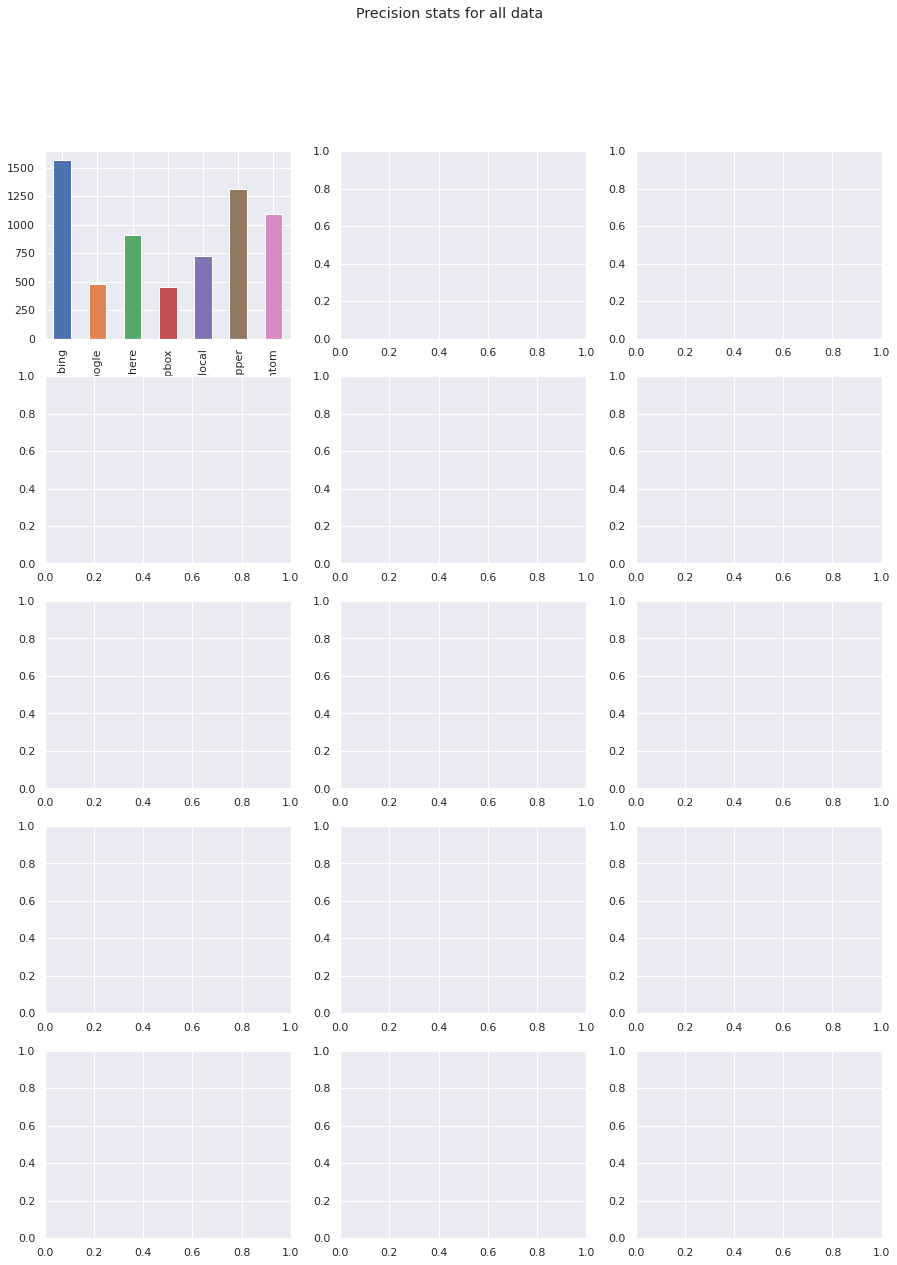

In [364]:
d = show_precision_stats(geocoded_data[geocoded_data.geocoder != "trillium"], "Precision stats for all data")

# img_name=f"{fig_path}/precision_stats_{dataset}.png"
# plt.savefig(img_name,  bbox_inches='tight')
# pdf_add_image(pdf, img_name, orientation='P', width=200)
pdf.savefig()
# plt.show()
# plt.close()


In [362]:
# d[~d.isnull().all(axis=1)].plot()
# geocoded_data[geocoded_data.geocoder != "trillium"]

In [ ]:
show_precision_stats(geocoded_data[geocoded_data.is_in_belgium], "Precision stats for data (in Belgium)")
pdf.savefig()

In [ ]:
show_precision_stats(geocoded_data[geocoded_data.is_reliable], "Precision stats for reliable data")

# img_name=f"{fig_path}/precision_stats_reliable_{dataset}.png"
# plt.savefig(img_name,  bbox_inches='tight')
# pdf_add_image(pdf, img_name, orientation='P', width=200)
pdf.savefig()
# plt.show()
# plt.close()


In [ ]:
# tics = sorted([10**i for i in range(6)] + [2*10**i for i in range(6)]  +[5*10**i for i in range(6)])
# pd.cut(geocoded_data.dist_to_median.dropna(), tics, include_lowest=True)

### Distribution

In [ ]:
def plot_dist_to_median_distrib(geocoded_data, plotter="px", title=None, filename=None):
    tics = sorted([0] + [10**i for i in range(1, 6)] + [2*10**i for i in range(1, 6)]  +[5*10**i for i in range(1, 6)])
    geocoded_data  = geocoded_data.dropna(subset=["dist_to_median"])
    geocoded_data = geocoded_data.assign(dist_to_median_bins = pd.cut(geocoded_data.dist_to_median, tics, include_lowest=True))
    df = geocoded_data.groupby(["dist_to_median_bins","geocoder"]).address.count().unstack()

    title = 'Distance to median'+(f" ({title})" if title else"")
    if plotter=="plt":

        ax = df.plot(figsize=(15,10), title=title)#.hist()
        ax.set_ylim(0, 100)
        if filename:
            plt.savefig(filename, bbox_inches='tight')

            
    else:
        df = df.reset_index()
        df["x"] = df.dist_to_median_bins.apply(lambda x: x.right)
        fig = px.line(df, x="x", y=geocoded_data.geocoder.unique(), title=title, log_x=True)
        #fig.set_ylim(0, 200)
        fig.show()

    #plt.savefig(f"{fig_path}/dist2med_distrib_{dataset}.png")

In [ ]:
# img_name=f"{fig_path}/dist2med_distrib_{dataset}.png"
img_name=None
plot_dist_to_median_distrib(geocoded_data[geocoded_data.geocoder != "trillium"], "plt", 
                            filename=img_name)

# pdf_add_image(pdf, img_name)
pdf.savefig()
# plt.show()
# plt.close()


In [ ]:
# img_name=f"{fig_path}/dist2med_distrib_reliable_{dataset}.png"

plot_dist_to_median_distrib(geocoded_data[geocoded_data.is_reliable], "plt", 
                            title="Reliable", 
                            filename=img_name)
# pdf_add_image(pdf, img_name)
pdf.savefig()
# plt.show()
# plt.close()



In [ ]:
addresses_found_by_NW = geocoded_data[(geocoded_data.geocoder == "nominatim_wrapper") & (geocoded_data.precision == "building")].address
if addresses_found_by_NW.shape[0]>0:
    plot_dist_to_median_distrib(geocoded_data[geocoded_data.address.isin(addresses_found_by_NW) & (geocoded_data.geocoder != "trillium")], 
                            title="for addr. found by NW at build. level")


### Ratio

In [ ]:
def plot_threshold_ratio(geocoded_data, plotter="px", title=None, filename=None):
    thresh_ratio = pd.DataFrame()
    for gc in geocoded_data.geocoder.unique():
        g_data = geocoded_data[geocoded_data.geocoder == gc]
        for thresh in [10**i for i in range(6)] + [2*10**i for i in range(6)]  +[5*10**i for i in range(6)]:
            thresh_ratio = pd.concat([thresh_ratio, pd.DataFrame([{"geocoder": gc, 
                                                "threshold": thresh, 
                                                "ratio": g_data[g_data.dist_to_median <= thresh].shape[0]/g_data.shape[0]}])])
    
    df = thresh_ratio.set_index("threshold").pivot(columns="geocoder", values="ratio")
    
    title = 'Ratio below threshold'+(f" ({title})" if title else"")
    if plotter=="plt":
        df.plot.line(logx=True, figsize=(15,10),  title=title)#x="ratio", y="threshold")
        if filename:
             plt.savefig(filename, bbox_inches='tight')
    else :
        fig = px.line(df, y=geocoded_data.geocoder.unique(), title=title, log_x=True)
        fig.show()

    ##return thresh_ratio

In [ ]:
# img_name=f"{fig_path}/dist2med_thresholds_{dataset}.png"

plot_threshold_ratio(geocoded_data, "plt")

pdf.savefig()
# plt.show()
# plt.close()


# pdf_add_image(pdf, img_name)

# plt.savefig(f"{fig_path}/dist2med_thresholds_{dataset}.png")

In [ ]:
# img_name=f"{fig_path}/dist2med_thresholds_reliable_{dataset}.png"

# plot_threshold_ratio(geocoded_data[geocoded_data.is_reliable], "plt", title="Reliable data", filename=img_name)

# pdf_add_image(pdf, img_name)


plot_threshold_ratio(geocoded_data[geocoded_data.is_reliable], "plt", title="Reliable data")

pdf.savefig()
# plt.show()
# plt.close()



#

In [ ]:
if addresses_found_by_NW.shape[0]>0:
    plot_threshold_ratio(geocoded_data[geocoded_data.address.isin(addresses_found_by_NW)], "plt", title="Addresses found by NW")

## Ratio far from median

In [ ]:
def get_far_from_threshold(geocoded_data, plotter="plt", filename=None, title=f"Number of results 'threshold' away from median ({ds})"):
    far_from_tresh = []
    #for thresh in [10**i for i in range(6)] + [2*10**i for i in range(6)]  +[5*10**i for i in range(6)]:
    for thresh in [10**i for i in range(2, 8)] + [2*10**i for i in range(2, 7)]  +[5*10**i for i in range(2, 7)]:
        d = geocoded_data[geocoded_data.dist_to_median > thresh].geocoder.value_counts().rename("count_far_from_med").reset_index().rename({"index": "geocoder"}, axis=1)
        d["threshold"] = thresh
        far_from_tresh.append(d)
    far_from_tresh = pd.concat(far_from_tresh)#.set_index("index")
    df = far_from_tresh.set_index("threshold").pivot(columns="geocoder", values="count_far_from_med")#.fillna(0)
    #display(df)
    if plotter=="plt":
        df.plot(logx=True, logy=False, figsize=(10,6), title=title)
        if filename:
             plt.savefig(filename, bbox_inches='tight')
    else:
        fig = px.line(df, y=geocoded_data.geocoder.unique(), title="Number of results 'threshold' away from median", log_x=True)
        fig.show()
    

In [ ]:
# img_name=f"{fig_path}/far_from_thresholds_{dataset}.png"

get_far_from_threshold(geocoded_data[geocoded_data.geocoder != "trillium"], "plt") #, img_name)

pdf.savefig()
# plt.show()
# plt.close()

# pdf_add_image(pdf, img_name)




In [ ]:
get_far_from_threshold(geocoded_data[(geocoded_data.precision=="building") & (geocoded_data.geocoder != "trillium")], 
                       title = f"Number of results 'threshold' away from median ({ds} - only 'building')")

pdf.savefig()

In [ ]:
# geocoded_data[(geocoded_data.precision=="building") & (geocoded_data.geocoder != "trillium")].shape[0]/geocoded_data[(geocoded_data.geocoder != "trillium")].shape[0]